# 📊 Análisis Completo de Series de Tiempo
## Dataset: Consumo Eléctrico (Electricity)

**Autor:** [Tu Nombre]  
**Fecha:** Diciembre 2025  
**Objetivo:** Análisis exploratorio completo de series de tiempo con enfoque en detección de no linealidad y estacionalidad

---

## 📑 Tabla de Contenidos

1. [Configuración Inicial](#1-configuracion)
2. [Importación y Preparación de Datos](#2-datos)
3. [Transformación Box-Cox (Estabilización de Varianza)](#3-boxcox)
4. [Descomposición de Series](#4-descomposicion)
5. [Eliminación de Tendencia](#5-tendencia)
6. [Análisis de Autocorrelación](#6-autocorrelacion)
7. [Tests de Estacionariedad](#7-estacionariedad)
8. [Tests de No Linealidad](#8-nolinealidad)
9. [Análisis de Heterocedasticidad](#9-heterocedasticidad)
10. [Detección de Cambios Estructurales](#10-cambios)
11. [Diagnóstico de Residuos](#11-diagnostico)
12. [Análisis de Estacionalidad](#12-estacionalidad)
13. [Análisis Espectral](#13-espectral)
14. [Preparación para Modelado](#14-modelado)

---

## 1. Configuración Inicial {#1-configuracion}



### 1.1 Instalación de Dependencias

**Instrucciones:**
- Asegúrate de tener R instalado (v4.0+)
- Instala `rpy2` en Python: `pip install rpy2`
- En Windows, puede ser necesario configurar `R_HOME`

In [2]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from gluonts.dataset.repository import get_dataset
import os

# Configuración de rpy2
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter

# Cargar extensión mágica para usar %%R
%load_ext rpy2.ipython

warnings.filterwarnings('ignore')

print("✅ Librerías Python cargadas correctamente")


c:\Users\pleal\Documents\Unal\Tesis\Codigo\Prediccion_Probabilistica\.venv\Lib\site-packages\gluonts\json.py:102: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
Error importing in API mode: ImportError('On Windows, cffi mode "ANY" is only "ABI".')
Trying to import in ABI mode.


✅ Librerías Python cargadas correctamente


In [3]:
def plot_(title, *series):
    """
    Función para crear gráficos interactivos estilo Bancolombia
    
    Args:
        title (str): Título del gráfico
        *series: Tuplas (x, y, label) para cada serie
    """
    fig = go.Figure()
    
    for x_variable, y_variable, label in series:
        fig.add_trace(go.Scatter(
            x=x_variable, y=y_variable, mode='lines', 
            name=label, line=dict(width=1.5)
        ))
    
    fig.update_layout(
        title=dict(text=title, x=0.5, xanchor='center'),
        template='plotly_white',
        margin=dict(t=120, b=100),
        legend=dict(
            orientation="h",
            yanchor="top",
            y=-0.3,
            xanchor="center",
            x=0.5
        )
    )

    fig.update_xaxes(
        type='date',
        rangeselector=dict(
            x=0,
            y=1.05,
            buttons=list([
                dict(count=24, label="24h", step="hour", stepmode="backward"),
                dict(count=7, label="1w", step="day", stepmode="backward"),
                dict(step="all")
            ])
        ),
        rangeslider=dict(visible=True)
    )

    fig.update_yaxes(autorange=True, title="Valor")
    fig.show()

print("✅ Función de graficado definida")

✅ Función de graficado definida


### 1.2 Instalación de Paquetes R

In [5]:
%%R

paquetes_necesarios <- c(
    "forecast",      # ARIMA, MSTL, Box-Cox
    "astsa",         # Análisis de series temporales avanzado
    "nonlinearTseries", # Tests de no linealidad
    "tidyverse",     # Manipulación de datos
    "lubridate",     # Manejo de fechas
    "tseries",       # ADF, KPSS
    "FinTS",         # Test ARCH
    "changepoint",   # Detección de cambios estructurales
    "nortest",       # Tests de normalidad
    "strucchange",   # Cambios estructurales
    "tsDyn"          # Modelos no lineales
)

for (pkg in paquetes_necesarios) {
    if (!require(pkg, character.only = TRUE)) {
        install.packages(pkg, dependencies = TRUE)
        library(pkg, character.only = TRUE)
    }
}

cat("✅ Todos los paquetes de R instalados correctamente\n")

-- Attaching core tidyverse packages ------------------------ tidyverse 2.0.0 --
v dplyr     1.1.4     v readr     2.1.5
v forcats   1.0.0     v stringr   1.5.1
v ggplot2   3.5.1     v tibble    3.2.1
v lubridate 1.9.4     v tidyr     1.3.1
v purrr     1.0.4     
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
i Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
<U+2705> Todos los paquetes de R instalados correctamente


Cargando paquete requerido: forecast
Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Cargando paquete requerido: astsa

Adjuntando el paquete: 'astsa'

The following object is masked from 'package:forecast':

    gas

Cargando paquete requerido: nonlinearTseries

Adjuntando el paquete: 'nonlinearTseries'

The following object is masked from 'package:grDevices':

    contourLines

Cargando paquete requerido: tidyverse
Cargando paquete requerido: tseries

    'tseries' version: 0.10-58

    'tseries' is a package for time series analysis and computational
    finance.

    See 'library(help="tseries")' for details.

Cargando paquete requerido: FinTS
Cargando paquete requerido: zoo

Adjuntando el paquete: 'zoo'

The following objects are masked from 'package:base':

    as.Date, as.Date.numeric


Adjuntando el paquete: 'FinTS'

The following object is masked from 'package:forecast':

    Acf

Cargando paquete requerido: changepoint
Success

---

## 2. Importación y Preparación de Datos {#2-datos}

**Descripción del Dataset:**
- **Fuente:** GluonTS - Dataset "Electricity"
- **Frecuencia:** Horaria
- **Variable:** Consumo eléctrico (kWh)
- **Ventana de análisis:** Últimas 2160 observaciones (~90 días)

In [6]:
dataset = get_dataset("electricity")
series_entry = next(iter(dataset.train))

# Configuración de ventana de análisis
LIMIT = 2160
values = series_entry['target'][-LIMIT:]
start_date = pd.Timestamp(series_entry['start'].to_timestamp())
freq = series_entry['start'].freq

# Crear índice temporal
timestamps = pd.date_range(
    end=start_date + pd.Timedelta(hours=len(series_entry['target'])), 
    periods=len(series_entry['target']), 
    freq=freq
)[-LIMIT:]

# Crear DataFrame
df = pd.DataFrame({'Date': timestamps, 'Consumo': values})
df.set_index('Date', inplace=True)

print(f"📊 Dimensiones del dataset: {df.shape}")
print(f"📅 Rango temporal: {df.index.min()} a {df.index.max()}")
print(f"📈 Estadísticas básicas:")
display(df.describe())
display(df.head())

📊 Dimensiones del dataset: (2160, 1)
📅 Rango temporal: 2014-02-25 21:00:00 a 2014-05-26 20:00:00
📈 Estadísticas básicas:


,Consumo
count,2160.000000
mean,15.743055
std,18.227098
min,0.000000
25%,8.000000
50%,10.000000
75%,12.000000
max,99.000000


,Consumo
Date,
2014-02-25 21:00:00,11.0
2014-02-25 22:00:00,11.0
2014-02-25 23:00:00,11.0
2014-02-26 00:00:00,11.0
2014-02-26 01:00:00,11.0


In [7]:
plot_('📈 Consumo Eléctrico Original', 
      (df.index, df["Consumo"], "Consumo (kWh)"))

### 2.1 Preparación para Análisis en R

⚠️ **Nota importante:** Detectamos si hay valores ≤ 0 para aplicar offset (Box-Cox requiere valores positivos)

In [8]:
df_r = df.reset_index()
df_r['Date'] = df_r['Date'].dt.strftime('%Y-%m-%d %H:%M:%S')

# Detección y corrección de valores no positivos
min_val = df_r['Consumo'].min()
offset = 0

if min_val <= 0:
    offset = abs(min_val) + 1.0
    print(f"⚠️ Valores ≤ 0 detectados. Aplicando offset de {offset}")
else:
    print("✅ Todos los valores son positivos")

df_r['Consumo_Offset'] = df_r['Consumo'] + offset
print(f"📊 Rango de valores: [{df_r['Consumo_Offset'].min():.2f}, {df_r['Consumo_Offset'].max():.2f}]")

⚠️ Valores ≤ 0 detectados. Aplicando offset de 1.0
📊 Rango de valores: [1.00, 100.00]


In [9]:
%%R -i df_r
# Celda 7: Convertir fechas en R
df_r$Date <- as.POSIXct(df_r$Date, format="%Y-%m-%d %H:%M:%S")
cat("✅ Datos cargados en R\n")
cat("Dimensiones:", nrow(df_r), "x", ncol(df_r), "\n")
head(df_r, 3)

<U+2705> Datos cargados en R
Dimensiones: 2160 x 3 
                 Date Consumo Consumo_Offset
0 2014-02-25 21:00:00      11             12
1 2014-02-25 22:00:00      11             12
2 2014-02-25 23:00:00      11             12


---

## 3. Transformación Box-Cox (Estabilización de Varianza) {#3-boxcox}

**Objetivo:** Estabilizar la varianza heterocedástica mediante transformación Box-Cox

**Teoría:**
- λ = 1 → Sin transformación
- λ = 0.5 → Raíz cuadrada
- λ = 0 → Logaritmo
- λ = -1 → Inverso


RESULTADOS:
Lambda estimado: -0.1181 
Interpretacion:
  Transformacion fuerte (similar a logaritmo)


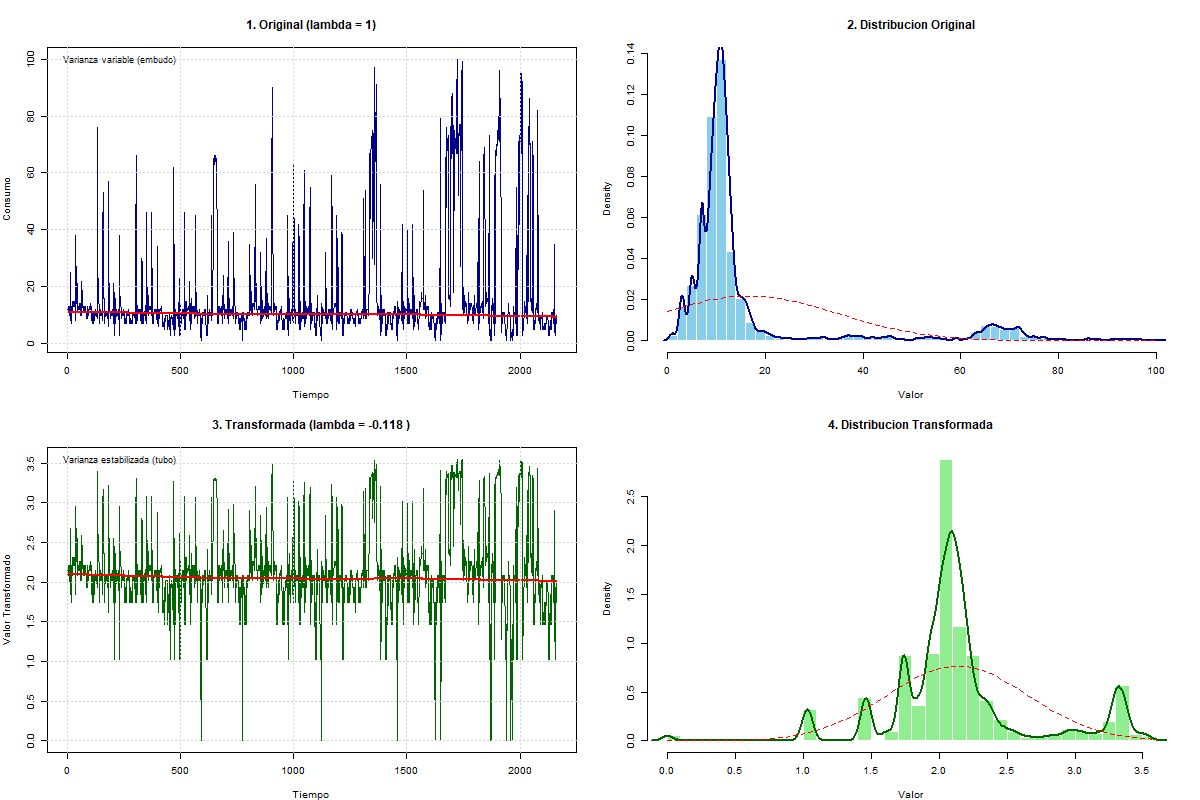

In [15]:
%%R -w 1200 -h 800
# Celda 8: Análisis Visual Box-Cox (4 paneles)

library(forecast)

# Calcular lambda optimo (método Guerrero para series temporales)
lambda_opt <- BoxCox.lambda(df_r$Consumo_Offset, method = "guerrero")

data_orig <- df_r$Consumo_Offset
data_trans <- BoxCox(df_r$Consumo_Offset, lambda_opt)

# Panel de 4 gráficos
par(mfrow=c(2,2), mar=c(4,4,4,2))

# 1. Serie Original
plot(data_orig, type="l", col="darkblue", 
     main="1. Original (lambda = 1)", ylab="Consumo", xlab="Tiempo")
lines(lowess(data_orig), col="red", lwd=2)
legend("topleft", legend="Varianza variable (embudo)", bty="n", cex=0.9)
grid()

# 2. Histograma Original
hist(data_orig, breaks=50, col="skyblue", border="white", probability=TRUE,
     main="2. Distribucion Original", xlab="Valor")
lines(density(data_orig), col="darkblue", lwd=2)
curve(dnorm(x, mean=mean(data_orig), sd=sd(data_orig)), 
      add=TRUE, col="red", lty=2)

# 3. Serie Transformada
plot(data_trans, type="l", col="darkgreen", 
     main=paste("3. Transformada (lambda =", round(lambda_opt, 3), ")"),
     ylab="Valor Transformado", xlab="Tiempo")
lines(lowess(data_trans), col="red", lwd=2)
legend("topleft", legend="Varianza estabilizada (tubo)", bty="n", cex=0.9)
grid()

# 4. Histograma Transformado
hist(data_trans, breaks=50, col="lightgreen", border="white", probability=TRUE,
     main="4. Distribucion Transformada", xlab="Valor")
lines(density(data_trans), col="darkgreen", lwd=2)
curve(dnorm(x, mean=mean(data_trans), sd=sd(data_trans)), 
      add=TRUE, col="red", lty=2)

par(mfrow=c(1,1))

cat("\nRESULTADOS:\n")
# Usamos 'lambda' en vez del símbolo griego para evitar problemas de encoding
cat("Lambda estimado:", round(lambda_opt, 4), "\n")
cat("Interpretacion:\n")
if (lambda_opt > 0.9) {
    cat("  -> Casi sin transformacion necesaria\n")
} else if (lambda_opt > 0.4) {
    cat("  Transformacion moderada (similar a raiz cuadrada)\n")
} else {
    cat("  Transformacion fuerte (similar a logaritmo)\n")
}

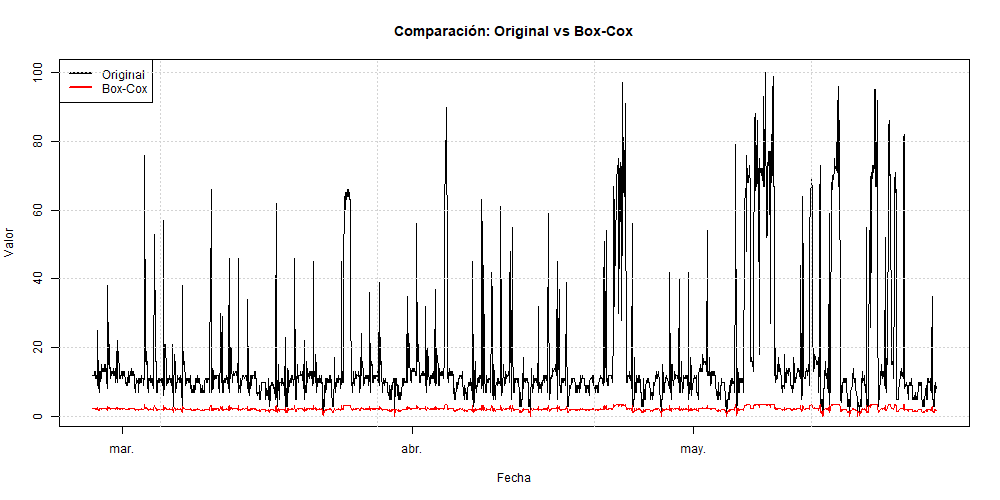

In [16]:
%%R -w 1000 -h 500
# Celda 9: Comparación Directa Original vs Box-Cox

Lambda_est <- BoxCox.lambda(df_r$Consumo_Offset, method = "guerrero")

plot(df_r$Date, df_r$Consumo_Offset, type="l", col="black", 
     main="Comparación: Original vs Box-Cox", ylab="Valor", xlab="Fecha")
lines(df_r$Date, BoxCox(df_r$Consumo_Offset, Lambda_est), col="red")
legend("topleft", legend=c("Original", "Box-Cox"), 
       col=c("black", "red"), lty=1, lwd=2)
grid()

# Guardar transformación
df_r$BoxCox_Consumo <- BoxCox(df_r$Consumo_Offset, Lambda_est)

In [ ]:
# Celda 10: Traer resultados a Python
df['BoxCox_Consumo'] = %R df_r$BoxCox_Consumo
lambda_r = %R Lambda_est

plot_(f'🔄 Estabilización de Varianza (Box-Cox λ={lambda_r[0]:.3f})', 
      (df.index, df["Consumo"], "Datos Originales"),
      (df.index, df["BoxCox_Consumo"], "Box-Cox Transformado"))

---

## 4. Descomposición de Series {#4-descomposicion}

**Método:** MSTL (Multiple Seasonal-Trend decomposition using Loess)

**Componentes:**
- **Tendencia:** Movimiento de largo plazo
- **Estacionalidad Diaria:** Ciclo de 24 horas
- **Estacionalidad Semanal:** Ciclo de 168 horas (7 días)
- **Residuo:** Componente aleatorio


--- COMPONENTES IDENTIFICADOS ---
1. Tendencia global
2. Estacionalidad diaria (24h)
3. Estacionalidad semanal (168h)
4. Componente residual


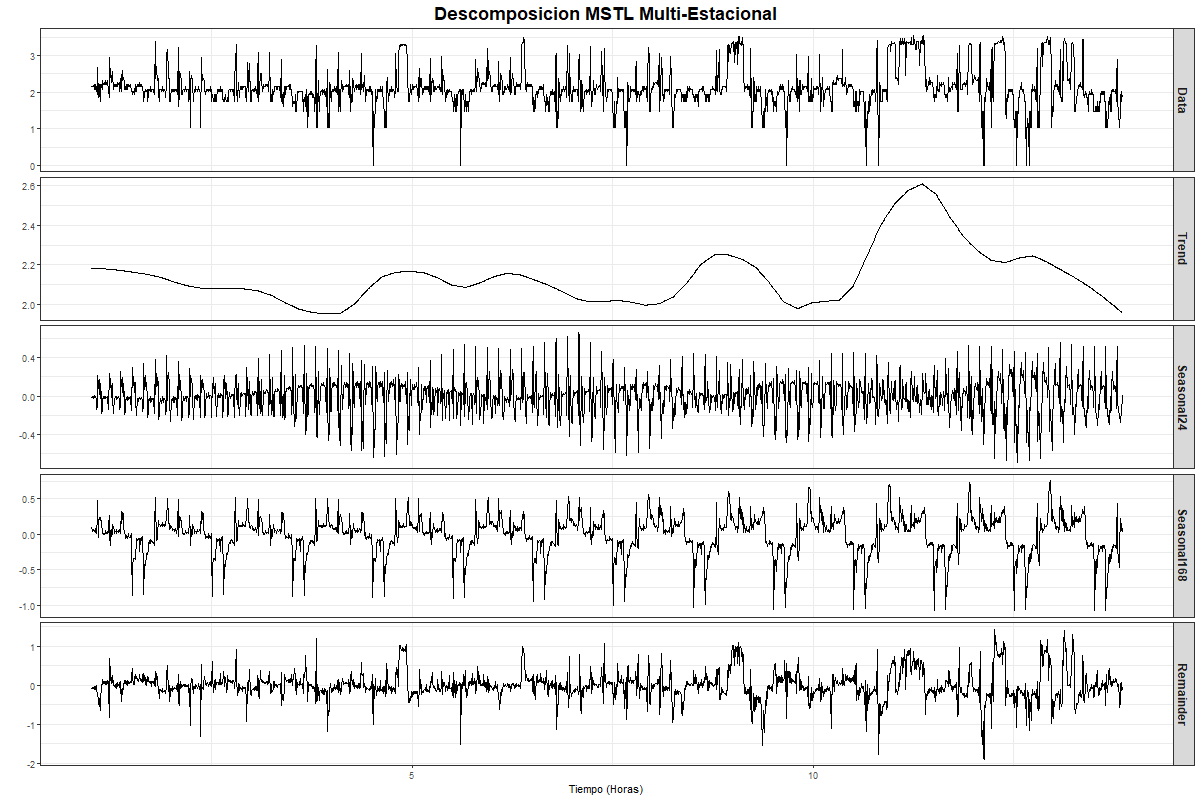

In [20]:
%%R -w 1200 -h 800
# Celda 11: Descomposicion MSTL

library(forecast)
library(ggplot2)

# Crear objeto multi-estacional
# Asegúrate de que df_r$BoxCox_Consumo existe de celdas anteriores
y_msts <- msts(df_r$BoxCox_Consumo, seasonal.periods=c(24, 168))

# Ajustar MSTL
fit_mstl <- mstl(y_msts)

# Visualizacion (Guardamos en variable p y usamos print)
p <- autoplot(fit_mstl) + 
  ggtitle("Descomposicion MSTL Multi-Estacional") +
  xlab("Tiempo (Horas)") +
  theme_bw() +
  theme(
    plot.title = element_text(size=18, face="bold", hjust=0.5),
    strip.text = element_text(size=12, face="bold")
  )

print(p)

cat("\n--- COMPONENTES IDENTIFICADOS ---\n")
cat("1. Tendencia global\n")
cat("2. Estacionalidad diaria (24h)\n")
cat("3. Estacionalidad semanal (168h)\n")
cat("4. Componente residual\n")

---

## 5. Eliminación de Tendencia {#5-tendencia}

**Método:** LOWESS (Locally Weighted Scatterplot Smoothing)

**Parámetros:**
- `f = 0.05`: Ventana de suavizado (5% de los datos)
- Menor f → Sigue más los datos locales
- Mayor f → Suavizado más pronunciado



 Tendencia extraida exitosamente
 Varianza antes: 0.2719 
 Varianza despues: 0.1797 


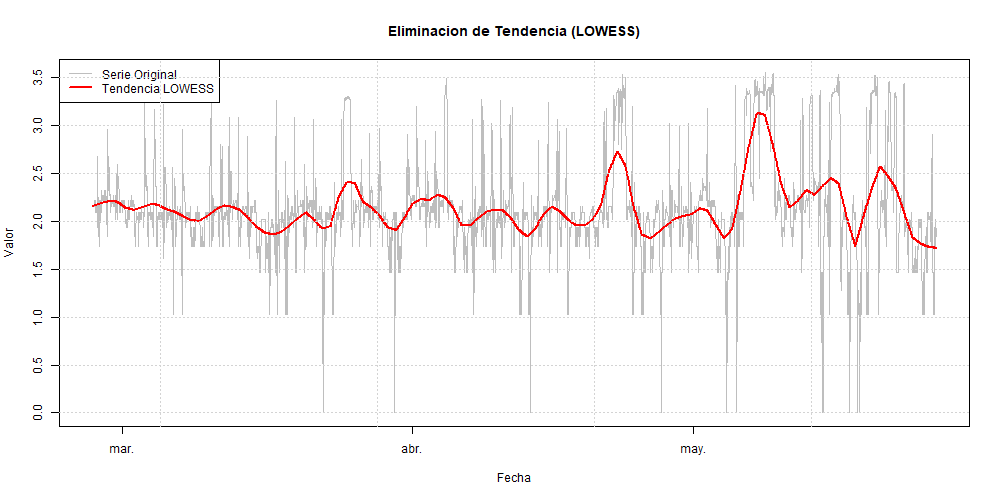

In [27]:
%%R -w 1000 -h 500
# Celda 12: Eliminación de Tendencia con LOWESS

trend_lowess_R <- lowess(df_r$BoxCox_Consumo, f = 0.05, iter = 0)

df_r$Trend <- trend_lowess_R$y
df_r$Trend_Removed <- df_r$BoxCox_Consumo - df_r$Trend

# Visualización
plot(df_r$Date, df_r$BoxCox_Consumo, type='l', col='gray', 
     main='Eliminacion de Tendencia (LOWESS)', 
     ylab='Valor', xlab='Fecha')
lines(df_r$Date, df_r$Trend, col='red', lwd=2)
legend("topleft", legend=c("Serie Original", "Tendencia LOWESS"), 
       col=c("gray", "red"), lty=1, lwd=c(1,2))
grid()

cat("\n Tendencia extraida exitosamente\n")
cat(" Varianza antes:", round(var(df_r$BoxCox_Consumo), 4), "\n")
cat(" Varianza despues:", round(var(df_r$Trend_Removed), 4), "\n")

In [26]:
df['Trend'] = %R df_r$Trend
df['Trend_Removed'] = %R df_r$Trend_Removed

plot_('Eliminación de Tendencia', 
      (df.index, df["BoxCox_Consumo"], "Box-Cox"),
      (df.index, df["Trend"], "Tendencia Suavizada"),
      (df.index, df["Trend_Removed"], "Residuo (Sin Tendencia)"))

---

## 6. Análisis de Autocorrelación {#6-autocorrelacion}

### 6.1 Gráfico de Rezagos (Lag Plot)

**Objetivo:** Visualizar correlaciones a diferentes rezagos

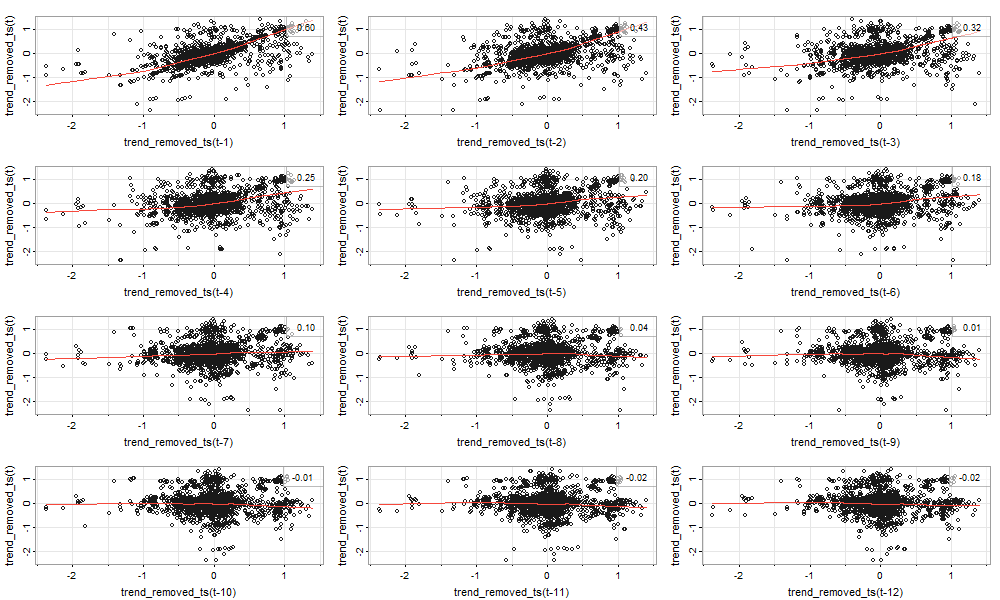

In [28]:
%%R -w 1000 -h 600
# Celda 14: Lag Plot (Primeros 12 rezagos)

library(astsa)

trend_removed_ts <- ts(df_r$Trend_Removed, frequency = 24)

options(repr.plot.width=20, repr.plot.height=6)
astsa::lag1.plot(trend_removed_ts, 12)

### 6.2 Función de Autocorrelación (ACF)

**Teoría:**
- Mide correlación entre la serie y sus rezagos
- Barras fuera de bandas → Correlación significativa
- Decaimiento lento → No estacionariedad
- Picos en 24, 48, 72... → Estacionalidad diaria


 BUSCAR:
- Picos en lag 24 - Ciclo diario
- Picos en lag 168 - Ciclo semanal
- Decaimiento rapido - Estacionariedad


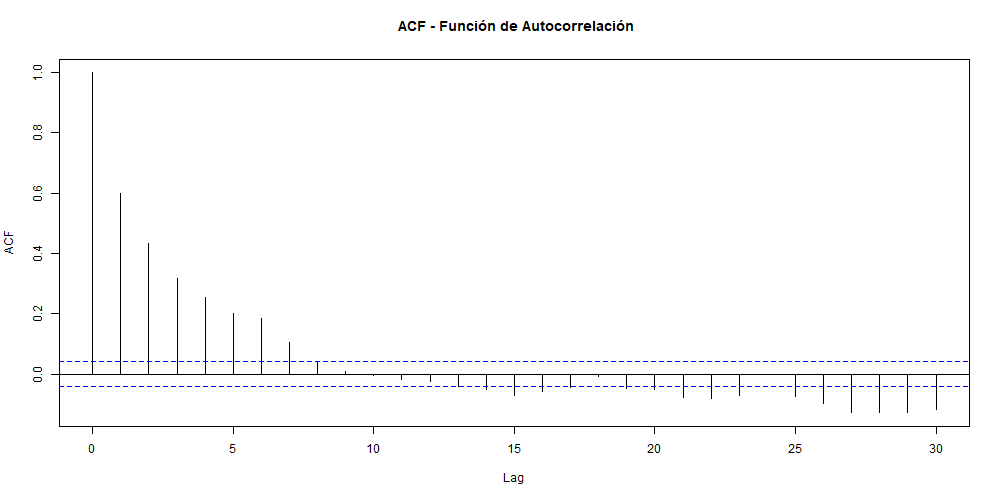

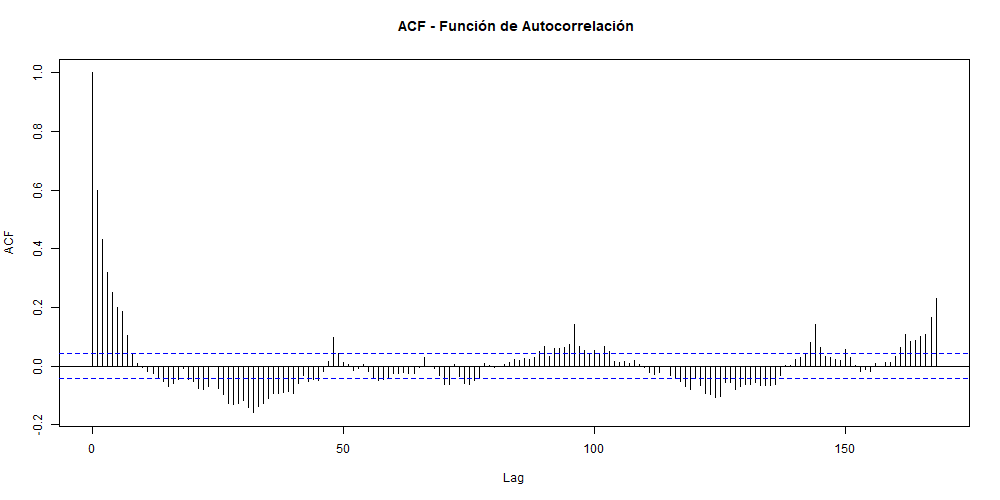

In [33]:
%%R -w 1000 -h 500
# Celda 15: ACF

acf(df_r$Trend_Removed, lag.max = 30, 
    main = " ACF - Función de Autocorrelación")


acf(df_r$Trend_Removed, lag.max = 168, 
    main = " ACF - Función de Autocorrelación")


cat("\n BUSCAR:\n")
cat("- Picos en lag 24 - Ciclo diario\n")
cat("- Picos en lag 168 - Ciclo semanal\n")
cat("- Decaimiento rapido - Estacionariedad\n")

### 6.3 Función de Autocorrelación Parcial (PACF)

**Diferencia con ACF:**
- PACF elimina efectos indirectos
- Útil para identificar orden AR en modelos ARIMA
- Corte abrupto → Indica orden del modelo

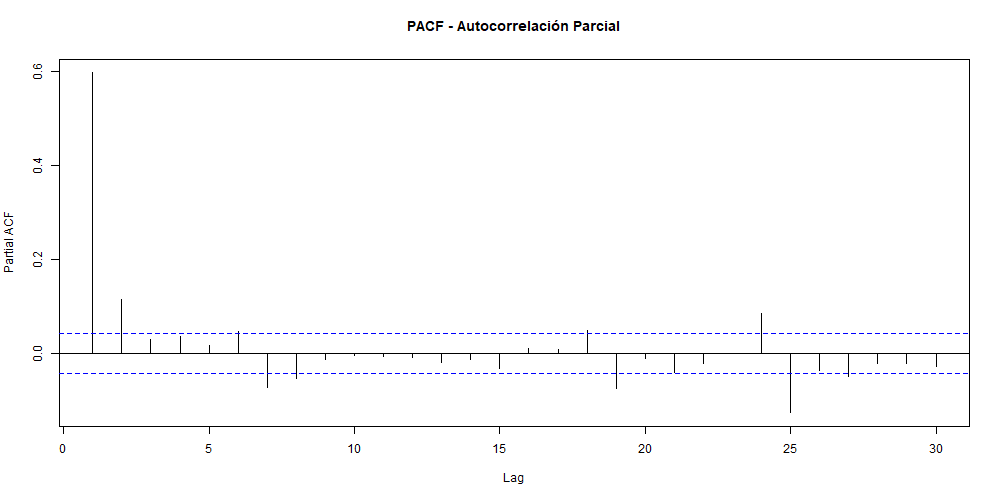

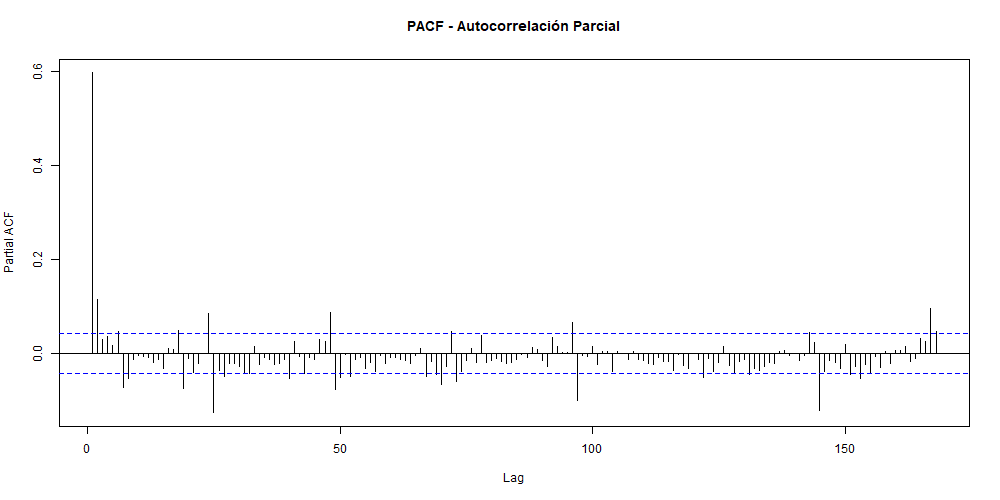

In [34]:
%%R -w 1000 -h 500
# Celda 16: PACF

pacf(df_r$Trend_Removed, lag.max = 30, 
     main = "PACF - Autocorrelación Parcial")

pacf(df_r$Trend_Removed, lag.max = 168, 
     main = "PACF - Autocorrelación Parcial")


### 6.4 Información Mutua

**Ventaja:** Detecta dependencias NO LINEALES que ACF/PACF no capturan

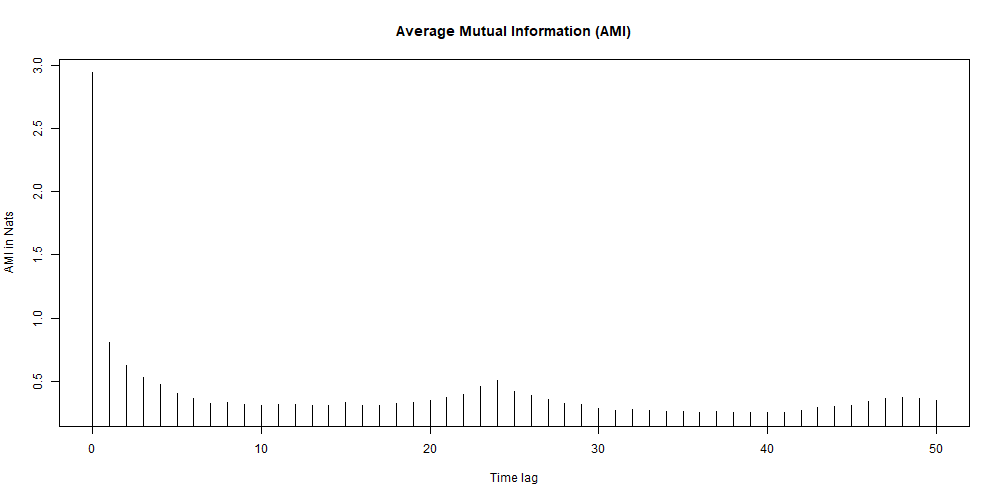

In [35]:
%%R -w 1000 -h 500
# Celda 17: Información Mutua

library(nonlinearTseries)

mi <- mutualInformation(
    df_r$Trend_Removed, 
    lag.max = 50, 
    n.partitions = 50, 
    units = "Nats", 
    do.plot = TRUE, 
    main="Información Mutua (Dependencia No Lineal)"
)

---

## 7. Tests de Estacionariedad {#7-estacionariedad}

**Estacionariedad:** Propiedades estadísticas constantes en el tiempo

**Tests complementarios:**
1. **ADF:** H₀ = No estacionaria (busca raíz unitaria)
2. **KPSS:** H₀ = Estacionaria (enfoque opuesto)

⚠️ **Buscar:** Rechazar ADF + No rechazar KPSS = Serie estacionaria

In [29]:
%%R
# Función auxiliar para interpretar p-values limpiamente
interpret_p <- function(p_val, alpha=0.05, h0_desc, h1_desc) {
    res <- ifelse(p_val < alpha, h1_desc, h0_desc)
    signif <- ifelse(p_val < 0.001, "***", ifelse(p_val < 0.01, "**", ifelse(p_val < 0.05, "*", "ns")))
    cat(sprintf("   -> p-value: %.5f (%s) \n   -> Conclusión: %s\n", p_val, signif, res))
}


 TESTS DE ESTACIONARIEDAD

[A] Augmented Dickey-Fuller (ADF)
    H0: La serie TIENE raiz unitaria (No estacionaria)
   p-value: 0.01000 (*)
   Conclusion: Se rechaza H0 (Serie Estacionaria)

[B] Kwiatkowski-Phillips-Schmidt-Shin (KPSS)
    H0: La serie ES estacionaria
   p-value: 0.10000 (ns)
   Conclusion: No se rechaza H0 (Serie Estacionaria)


In addition: Warning messages:
1: In adf.test(serie_analisis) : p-value smaller than printed p-value
2: In kpss.test(serie_analisis) : p-value greater than printed p-value


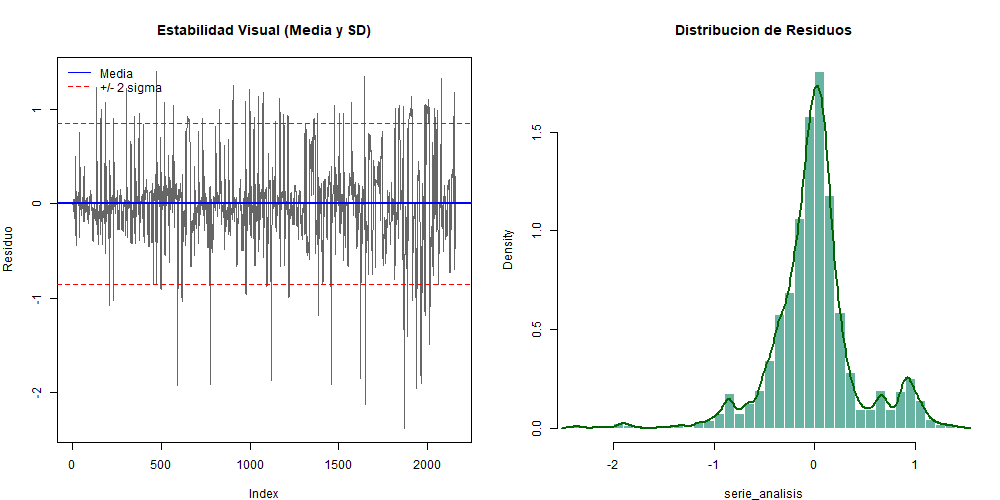

In [36]:
%%R -w 1000 -h 500
# Celda 18: Tests de Estacionariedad

library(tseries)

# Funcion auxiliar para interpretar p-values (sin acentos)
interpret_p <- function(p_val, alpha=0.05, h0_desc, h1_desc) {
    res <- ifelse(p_val < alpha, h1_desc, h0_desc)
    signif <- ifelse(p_val < 0.001, "***", 
                     if (p_val < 0.01) "**" else if (p_val < 0.05) "*" else "ns")
    cat(sprintf("   p-value: %.5f (%s)\n   Conclusion: %s\n", 
                p_val, signif, res))
}

serie_analisis <- na.omit(df_r$Trend_Removed)

# Visualizacion
par(mfrow=c(1,2), mar=c(4,4,4,2))

plot(serie_analisis, type='l', col='gray40', 
     main="Estabilidad Visual (Media y SD)", ylab="Residuo")
abline(h=mean(serie_analisis), col="blue", lwd=2)
abline(h=mean(serie_analisis) + 2*sd(serie_analisis), 
       col="red", lty=2)
abline(h=mean(serie_analisis) - 2*sd(serie_analisis), 
       col="red", lty=2)
legend("topleft", legend=c("Media", "+/- 2 sigma"), 
       col=c("blue", "red"), lty=c(1,2), bty="n")

hist(serie_analisis, breaks=40, col="#69b3a2", border="white", 
     main="Distribucion de Residuos", probability=TRUE)
lines(density(serie_analisis), col="darkgreen", lwd=2)

par(mfrow=c(1,1))

# Tests
cat("\n" , rep("=", 60), "\n", sep="")
cat(" TESTS DE ESTACIONARIEDAD\n")
cat(rep("=", 60), "\n", sep="")

# 1. ADF Test
cat("\n[A] Augmented Dickey-Fuller (ADF)\n")
cat("    H0: La serie TIENE raiz unitaria (No estacionaria)\n")
test_adf <- adf.test(serie_analisis)
interpret_p(test_adf$p.value, 0.05, 
            "No se rechaza H0 (Serie No Estacionaria)", 
            "Se rechaza H0 (Serie Estacionaria)")

# 2. KPSS Test
cat("\n[B] Kwiatkowski-Phillips-Schmidt-Shin (KPSS)\n")
cat("    H0: La serie ES estacionaria\n")
test_kpss <- kpss.test(serie_analisis)
interpret_p(test_kpss$p.value, 0.05, 
            "No se rechaza H0 (Serie Estacionaria)", 
            "Se rechaza H0 (Serie No Estacionaria)")

---

## 8. Tests de No Linealidad {#8-nolinealidad}

**¿Por qué importa?**
- Modelos lineales (ARIMA) asumen linealidad
- Si hay no linealidad → LSTM/GRU/Transformer son superiores
- Justifica métodos avanzados en tu tesis

### 8.1 Batería Completa en Python

In [38]:
# Celda 19: Tests de No Linealidad (Implementación Robusta)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.tsa.stattools import acf
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.linear_model import LinearRegression, Ridge
import warnings
warnings.filterwarnings('ignore')

# ============================================================================
# FUNCIONES DE TESTS
# ============================================================================

def bds_test_python(series, m=2, epsilon=None):
    """Test BDS simplificado para dependencia no lineal"""
    series = np.array(series)
    n = len(series)
    
    if epsilon is None:
        epsilon = 0.5 * np.std(series)
    
    def correlation_integral(data, eps, m):
        N = len(data) - m + 1
        vectors = np.array([data[i:i+m] for i in range(N)])
        
        count = 0
        for i in range(N):
            for j in range(i+1, N):
                if np.max(np.abs(vectors[i] - vectors[j])) < eps:
                    count += 1
        
        C_m = 2 * count / (N * (N - 1))
        return C_m if C_m > 0 else 1e-10
    
    C_1 = correlation_integral(series, epsilon, 1)
    C_m = correlation_integral(series, epsilon, m)
    V_mn = n * (C_m - C_1**m)
    sigma = np.sqrt(4 * (C_1**(2*m) + 2*sum([C_1**(2*k) for k in range(1,m)])))
    
    z_stat = V_mn / (sigma * np.sqrt(n)) if sigma > 0 else 0
    p_value = 2 * (1 - stats.norm.cdf(abs(z_stat)))
    
    return z_stat, p_value

def mcleod_li_test(series, lags=24):
    """Test McLeod-Li (Ljung-Box en residuos²)"""
    residuals = series - np.mean(series)
    squared_resid = residuals ** 2
    lb_result = acorr_ljungbox(squared_resid, lags=[lags], return_df=True)
    return lb_result

def tsay_test(series, lag=1, order=2):
    """Test de Tsay para no linealidad estructural"""
    n = len(series)
    X, y = [], []
    
    for i in range(lag * order, n):
        features = [series[i - j * lag] for j in range(1, order + 1)]
        X.append(features)
        y.append(series[i])
    
    X, y = np.array(X), np.array(y)
    
    # Regresión lineal
    model = LinearRegression()
    model.fit(X, y)
    residuals = y - model.predict(X)
    
    # Características no lineales
    X_nonlinear = []
    for i in range(len(X)):
        row = list(X[i])
        row.extend([x**2 for x in X[i]])
        for j in range(len(X[i])):
            for k in range(j+1, len(X[i])):
                row.append(X[i][j] * X[i][k])
        X_nonlinear.append(row)
    
    X_nonlinear = np.array(X_nonlinear)
    
    # Regresión de residuos²
    model_nl = Ridge(alpha=1.0)
    model_nl.fit(X_nonlinear, residuals**2)
    r2 = model_nl.score(X_nonlinear, residuals**2)
    
    n_samples = len(residuals)
    k = X_nonlinear.shape[1]
    
    if r2 < 1:
        f_stat = (r2 / k) / ((1 - r2) / (n_samples - k - 1))
        p_value = 1 - stats.f.cdf(f_stat, k, n_samples - k - 1)
    else:
        f_stat = np.inf
        p_value = 0
    
    return f_stat, p_value, r2

def hurst_exponent(series, max_lag=20):
    """Exponente de Hurst para memoria larga"""
    lags = range(2, max_lag)
    tau = []
    
    for lag in lags:
        n_subseries = len(series) // lag
        subseries = [series[i*lag:(i+1)*lag] for i in range(n_subseries)]
        
        rs_values = []
        for sub in subseries:
            if len(sub) == 0:
                continue
            mean_sub = np.mean(sub)
            cumdev = np.cumsum(sub - mean_sub)
            R = np.max(cumdev) - np.min(cumdev)
            S = np.std(sub)
            if S > 0:
                rs_values.append(R / S)
        
        if rs_values:
            tau.append(np.mean(rs_values))
        else:
            tau.append(np.nan)
    
    tau = np.array(tau)
    lags = np.array(list(lags))
    
    valid = ~np.isnan(tau) & (tau > 0)
    if sum(valid) < 2:
        return np.nan
    
    log_lags = np.log(lags[valid])
    log_tau = np.log(tau[valid])
    
    slope, intercept = np.polyfit(log_lags, log_tau, 1)
    return slope

# ============================================================================
# EJECUCIÓN DE TESTS
# ============================================================================

serie = df['Trend_Removed'].dropna().values

print("="*70)
print("   BATERÍA DE TESTS DE NO LINEALIDAD")
print("="*70)
print()

# Test 1: BDS
print("-" * 70)
print(" [1] TEST BDS (Detección de Dependencia No Lineal)")
print("-" * 70)
z_stat, p_val = bds_test_python(serie, m=2)
print(f"  Estadístico Z: {z_stat:.4f}")
print(f"  p-value: {p_val:.6f}", end="")

if p_val < 0.001:
    print(" ***")
    print("  ✓ Fuerte evidencia de dependencia no lineal")
    print("  → Justifica uso de redes neuronales sobre ARIMA")
elif p_val < 0.05:
    print(" *")
    print("  ✓ Evidencia de dependencia no lineal")
else:
    print(" (ns)")
    print("  ✗ No hay evidencia clara")
print()

# Test 2: McLeod-Li
print("-" * 70)
print(" [2] TEST McLEOD-LI (Varianza Condicional)")
print("-" * 70)
ml_result = mcleod_li_test(serie, lags=24)
lb_stat = ml_result['lb_stat'].values[0]
lb_pval = ml_result['lb_pvalue'].values[0]

print(f"  Estadístico LB: {lb_stat:.4f}")
print(f"  p-value: {lb_pval:.6f}", end="")

if lb_pval < 0.001:
    print(" ***")
    print("  ✓ Fuerte evidencia de efectos ARCH/GARCH")
    print("  → Usar predicción probabilística (cuantiles)")
elif lb_pval < 0.05:
    print(" *")
    print("  ✓ Evidencia de heterocedasticidad condicional")
else:
    print(" (ns)")
    print("  ✗ Varianza relativamente estable")
print()

# Test 3: Tsay
print("-" * 70)
print(" [3] TEST DE TSAY (No Linealidad Estructural)")
print("-" * 70)
f_stat, p_val, r2 = tsay_test(serie, lag=1, order=3)
print(f"  Estadístico F: {f_stat:.4f}")
print(f"  R² (no lineal): {r2:.4f}")
print(f"  p-value: {p_val:.6f}", end="")

if p_val < 0.001:
    print(" ***")
    print("  ✓ Fuerte no linealidad detectada")
    print("  → Modelos lineales serán insuficientes")
elif p_val < 0.05:
    print(" *")
    print("  ✓ No linealidad presente")
else:
    print(" (ns)")
    print("  ✗ Estructura lineal dominante")
print()

# Test 4: Hurst
print("-" * 70)
print(" [4] EXPONENTE DE HURST (Memoria Larga)")
print("-" * 70)
H = hurst_exponent(serie, max_lag=50)
print(f"  H = {H:.4f}")
print()
print("  Interpretación:")
if H > 0.55:
    print(f"  → Persistencia (H > 0.5): Tendencias se mantienen")
    print(f"  → Memoria larga detectada")
elif H < 0.45:
    print(f"  → Anti-persistencia (H < 0.5): Reversión a la media")
else:
    print(f"  → Random walk (H ≈ 0.5): Sin memoria significativa")
print()

print("="*70)
print("   RESUMEN PARA JUSTIFICACIÓN EN TESIS")
print("="*70)
print()
print("✓ BDS rechaza → Dependencia compleja justifica LSTM/Transformer")
print("✓ McLeod-Li rechaza → Usar CRPS sobre MSE (predicción probabilística)")
print("✓ Tsay rechaza → Modelos no lineales necesarios")
print("✓ Hurst > 0.5 → Efectos de largo plazo importantes")
print("="*70)

   BATERÍA DE TESTS DE NO LINEALIDAD

----------------------------------------------------------------------
 [1] TEST BDS (Detección de Dependencia No Lineal)
----------------------------------------------------------------------
  Estadístico Z: 3.7588
  p-value: 0.000171 ***
  ✓ Fuerte evidencia de dependencia no lineal
  → Justifica uso de redes neuronales sobre ARIMA

----------------------------------------------------------------------
 [2] TEST McLEOD-LI (Varianza Condicional)
----------------------------------------------------------------------
  Estadístico LB: 1551.8782
  p-value: 0.000000 ***
  ✓ Fuerte evidencia de efectos ARCH/GARCH
  → Usar predicción probabilística (cuantiles)

----------------------------------------------------------------------
 [3] TEST DE TSAY (No Linealidad Estructural)
----------------------------------------------------------------------
  Estadístico F: 26.9655
  R² (no lineal): 0.1016
  p-value: 0.000000 ***
  ✓ Fuerte no linealidad detectada

### 8.2 Visualizaciones de No Linealidad

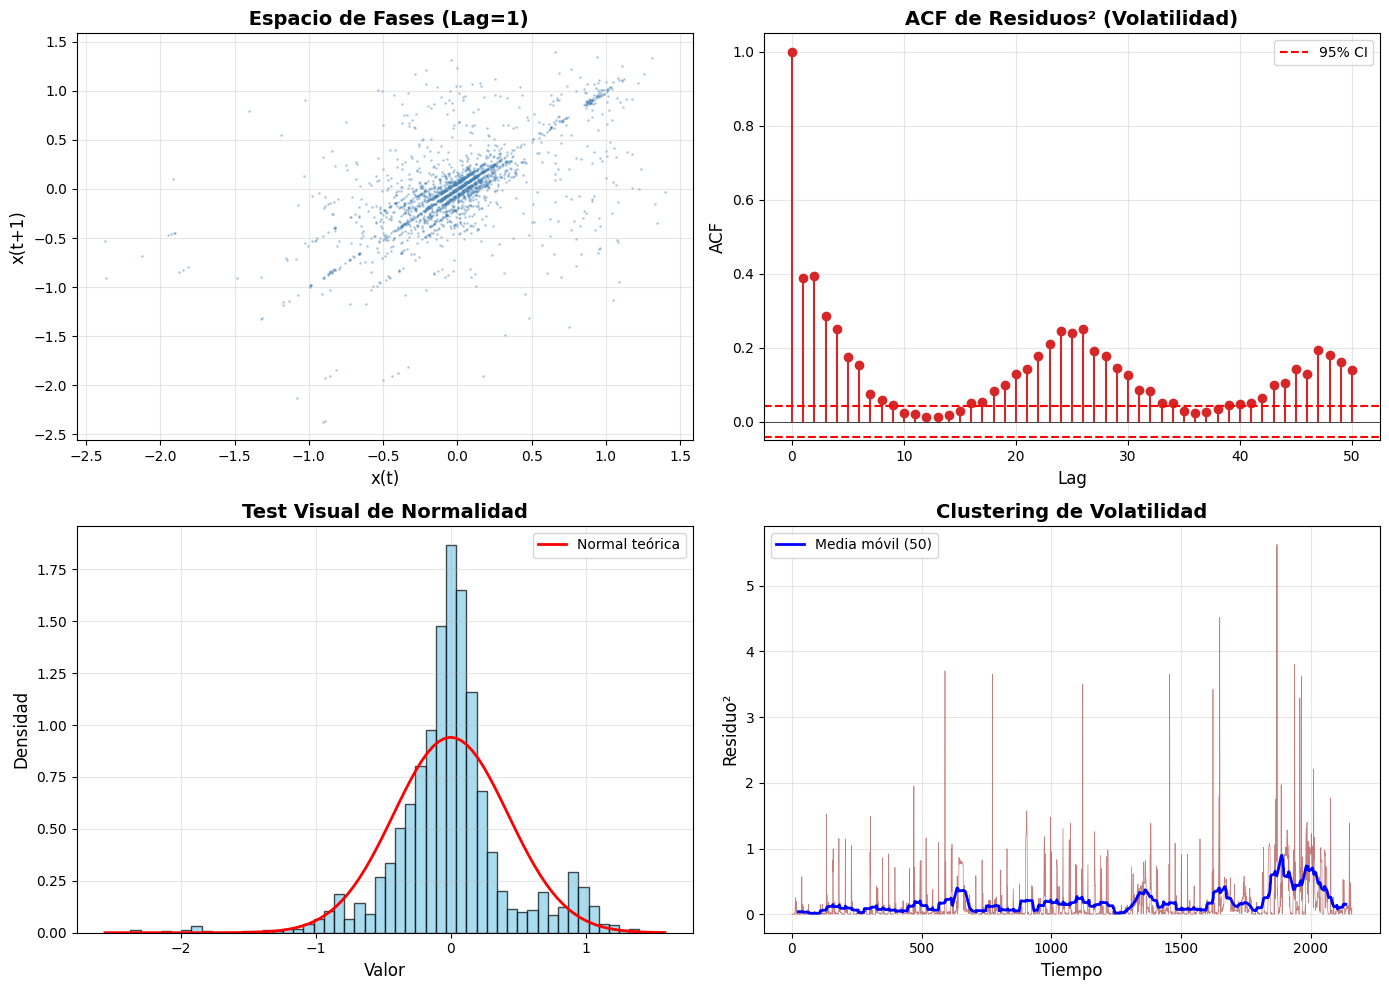

In [41]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Espacio de Fases (Atractor)
ax1 = axes[0, 0]
lag = 1
ax1.scatter(serie[:-lag], serie[lag:], alpha=0.3, s=1, c='steelblue')
ax1.set_xlabel('x(t)', fontsize=12)
ax1.set_ylabel(f'x(t+{lag})', fontsize=12)
ax1.set_title(' Espacio de Fases (Lag=1)', fontsize=14, fontweight='bold')
ax1.grid(alpha=0.3)

# 2. ACF de Residuos² (Test Visual McLeod-Li)
ax2 = axes[0, 1]
squared_acf = acf(serie**2, nlags=50)
ax2.stem(squared_acf, linefmt='C3-', markerfmt='C3o', basefmt=' ')
ax2.axhline(y=0, color='k', linestyle='-', linewidth=0.5)
ax2.axhline(y=1.96/np.sqrt(len(serie)), color='r', linestyle='--', label='95% CI')
ax2.axhline(y=-1.96/np.sqrt(len(serie)), color='r', linestyle='--')
ax2.set_title('ACF de Residuos² (Volatilidad)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Lag', fontsize=12)
ax2.set_ylabel('ACF', fontsize=12)
ax2.legend()
ax2.grid(alpha=0.3)

# 3. Distribución vs Normal
ax3 = axes[1, 0]
ax3.hist(serie, bins=50, density=True, alpha=0.7, color='skyblue', edgecolor='black')
from scipy.stats import norm
xmin, xmax = ax3.get_xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, np.mean(serie), np.std(serie))
ax3.plot(x, p, 'r-', linewidth=2, label='Normal teórica')
ax3.set_title('Test Visual de Normalidad', fontsize=14, fontweight='bold')
ax3.set_xlabel('Valor', fontsize=12)
ax3.set_ylabel('Densidad', fontsize=12)
ax3.legend()
ax3.grid(alpha=0.3)

# 4. Volatilidad (Clustering)
ax4 = axes[1, 1]
ax4.plot(serie**2, color='darkred', alpha=0.5, linewidth=0.5)
window = 50
smoothed = pd.Series(serie**2).rolling(window=window, center=True).mean()
ax4.plot(smoothed, color='blue', linewidth=2, label=f'Media móvil ({window})')
ax4.set_title('Clustering de Volatilidad', fontsize=14, fontweight='bold')
ax4.set_xlabel('Tiempo', fontsize=12)
ax4.set_ylabel('Residuo²', fontsize=12)
ax4.legend()
ax4.grid(alpha=0.3)

plt.tight_layout()
plt.show()


---

## 9. Análisis de Heterocedasticidad {#9-heterocedasticidad}

**Objetivo:** Detectar varianza condicional (efectos ARCH)

**Implicaciones:**
- Varianza cambiante en el tiempo
- Predicciones puntuales insuficientes
- Necesidad de intervalos probabilísticos


 TEST DE HETEROCEDASTICIDAD (ARCH-LM)

[ARCH-LM Test]
H0: No hay efectos ARCH (Varianza constante)

   p-value: 0.00000 (***)
   Conclusion: Heterocedastico (Varianza cambiante)

RECOMENDACION:
- Considerar modelos GARCH/EGARCH
- Usar prediccion probabilistica (cuantiles)
- CRPS como metrica principal vs MSE


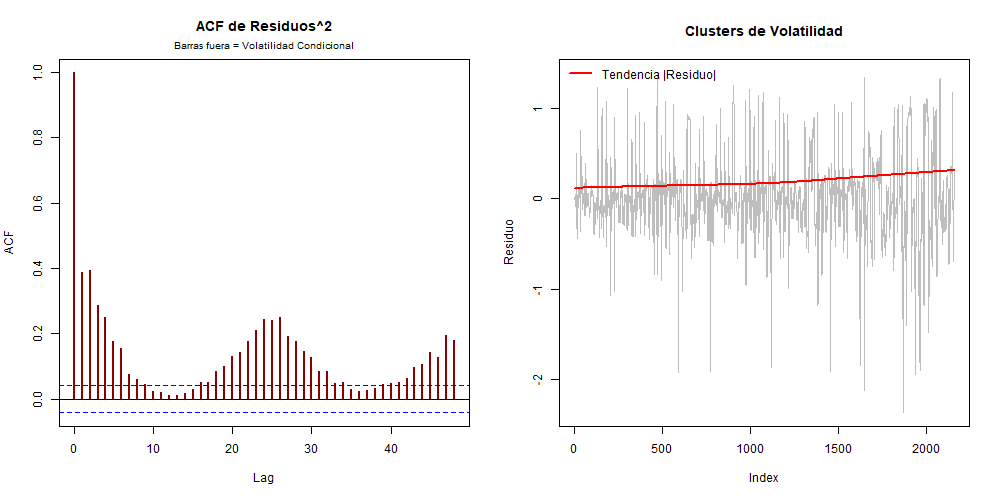

In [43]:
%%R -w 1000 -h 500
# Celda 21: Test ARCH-LM

library(FinTS)

serie_residuos <- na.omit(df_r$Trend_Removed)

par(mfrow=c(1,2))

# 1. ACF de residuos al cuadrado (Cambiado ² por ^2)
acf(serie_residuos^2, lag.max=48, 
    main="ACF de Residuos^2", col="darkred", lwd=2)
mtext("Barras fuera = Volatilidad Condicional", side=3, line=0.5, cex=0.8)

# 2. Clustering visual
plot(serie_residuos, type="l", col="gray", 
     main="Clusters de Volatilidad", ylab="Residuo")
lines(lowess(abs(serie_residuos)), col="red", lwd=2)
legend("topleft", legend="Tendencia |Residuo|", col="red", lwd=2, bty="n")

par(mfrow=c(1,1))

# Funcion auxiliar (Sin acento en Conclusion)
interpret_p <- function(p_val, alpha=0.05, h0_desc, h1_desc) {
    res <- ifelse(p_val < alpha, h1_desc, h0_desc)
    signif <- ifelse(p_val < 0.001, "***", 
                     ifelse(p_val < 0.01, "**", 
                            ifelse(p_val < 0.05, "*", "ns")))
    cat(sprintf("   p-value: %.5f (%s)\n   Conclusion: %s\n", 
                p_val, signif, res))
}

cat("\n", rep("=", 60), "\n", sep="")
cat(" TEST DE HETEROCEDASTICIDAD (ARCH-LM)\n")
cat(rep("=", 60), "\n", sep="")

cat("\n[ARCH-LM Test]\n")
cat("H0: No hay efectos ARCH (Varianza constante)\n\n") # Cambiado H0

test_arch <- ArchTest(serie_residuos, lags=24)
interpret_p(test_arch$p.value, 
            h0_desc="Homocedastico (Varianza estable)", 
            h1_desc="Heterocedastico (Varianza cambiante)") # Sin acento

if(test_arch$p.value < 0.05) {
    cat("\nRECOMENDACION:\n")
    cat("- Considerar modelos GARCH/EGARCH\n") # Cambiado viñeta
    cat("- Usar prediccion probabilistica (cuantiles)\n") # Sin acentos
    cat("- CRPS como metrica principal vs MSE\n") # Sin acento
}

---

## 10. Detección de Cambios Estructurales {#10-cambios}

**Método:** PELT (Pruned Exact Linear Time)

**Aplicaciones:**
- Detectar cambios de régimen
- Identificar eventos especiales
- Validar estabilidad del modelo



--- RESULTADOS ---
  Cambios detectados: 146 

--- Primeras 5 fechas ---
  1. Indice 5 : 2014-02-26 01:00:00
  2. Indice 48 : 2014-02-27 20:00:00
  3. Indice 50 : 2014-02-27 22:00:00
  4. Indice 52 : 2014-02-28
  5. Indice 54 : 2014-02-28 02:00:00

--- INTERPRETACION ---
  - Cambios pueden indicar:
    * Eventos climaticos extremos
    * Cambios en patrones de consumo
    * Intervenciones en el sistema
  - Considerar variables exogenas en estos periodos


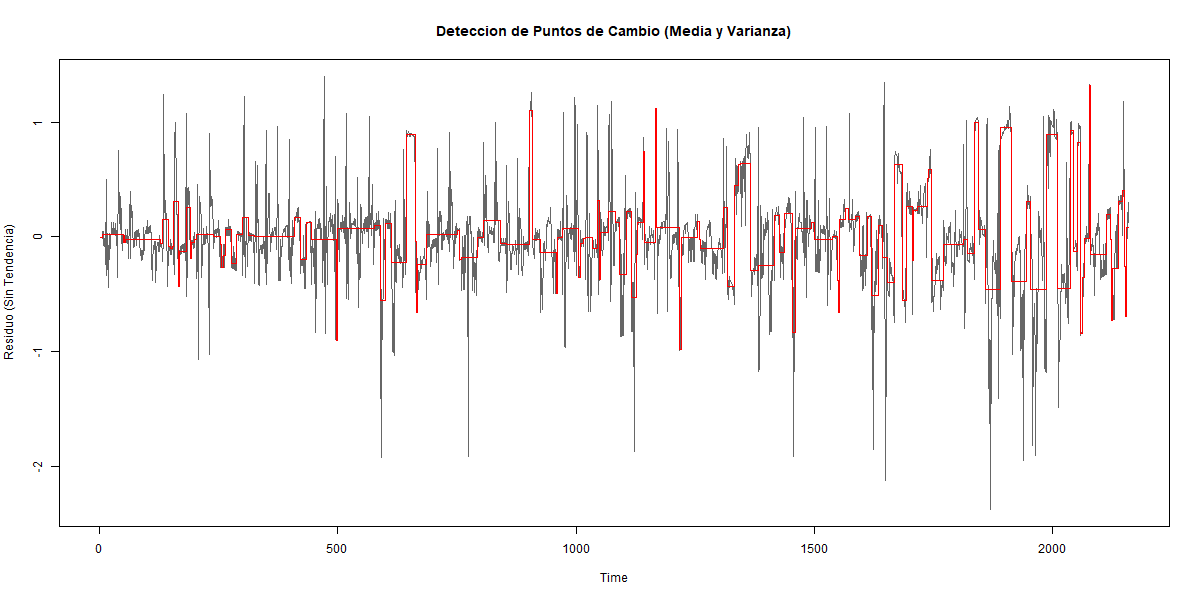

In [45]:
%%R -w 1200 -h 600
# Celda 22: Change Point Detection

library(changepoint)

# PELT con penalizacion BIC (sin acento)
# Asumiendo que df_r$Trend_Removed existe
cpt_obj <- cpt.meanvar(na.omit(df_r$Trend_Removed), 
                       method = "PELT", 
                       penalty = "BIC")

# Visualizacion
plot(cpt_obj, type = "l", col = "gray40", 
     main = "Deteccion de Puntos de Cambio (Media y Varianza)", 
     ylab = "Residuo (Sin Tendencia)")

# Extraer indices
cpts_indices <- cpts(cpt_obj)

if(length(cpts_indices) > 0) {
    cat("\n--- RESULTADOS ---\n")
    cat(paste("  Cambios detectados:", length(cpts_indices), "\n"))
    
    cat("\n--- Primeras 5 fechas ---\n")
    for(i in 1:min(5, length(cpts_indices))) {
        idx <- cpts_indices[i]
        # Aseguramos que la fecha sea string para evitar problemas de tipos
        fecha_str <- as.character(df_r$Date[idx])
        cat(sprintf("  %d. Indice %d : %s\n", 
                    i, idx, fecha_str))
    }
    
    cat("\n--- INTERPRETACION ---\n")
    cat("  - Cambios pueden indicar:\n")
    cat("    * Eventos climaticos extremos\n")
    cat("    * Cambios en patrones de consumo\n")
    cat("    * Intervenciones en el sistema\n")
    cat("  - Considerar variables exogenas en estos periodos\n")
} else {
    cat("\n--- No se detectaron cambios estructurales significativos ---\n")
    cat("   * Serie relativamente estable\n")
}

---

## 11. Diagnóstico de Residuos {#11-diagnostico}

**Objetivo:** Validar que los residuos son "ruido blanco"

**Pruebas:**
1. **Jarque-Bera:** Normalidad
2. **Ljung-Box:** Independencia (no autocorrelación)


 DIAGNOSTICO DE RESIDUOS

[A] Test de Jarque-Bera (Normalidad):
   p-value: 0.00000
   Resultado: No Normal

[B] Test Ljung-Box (Independencia - Es ruido blanco?):
   p-value: 0.00000
   Resultado: Autocorrelacion presente

--- CONCLUSIONES ---
1. NO NORMALIDAD (Kurtosis > 3 o asimetria):
   -> Justifica uso de metricas robustas (CRPS, QuantileLoss)

2. AUTOCORRELACION RESIDUAL indica:
   - LOWESS no capturo toda la dinamica temporal
   - Modelos ARMA/LSTM manejaran esta estructura
   - Es normal en esta etapa exploratoria


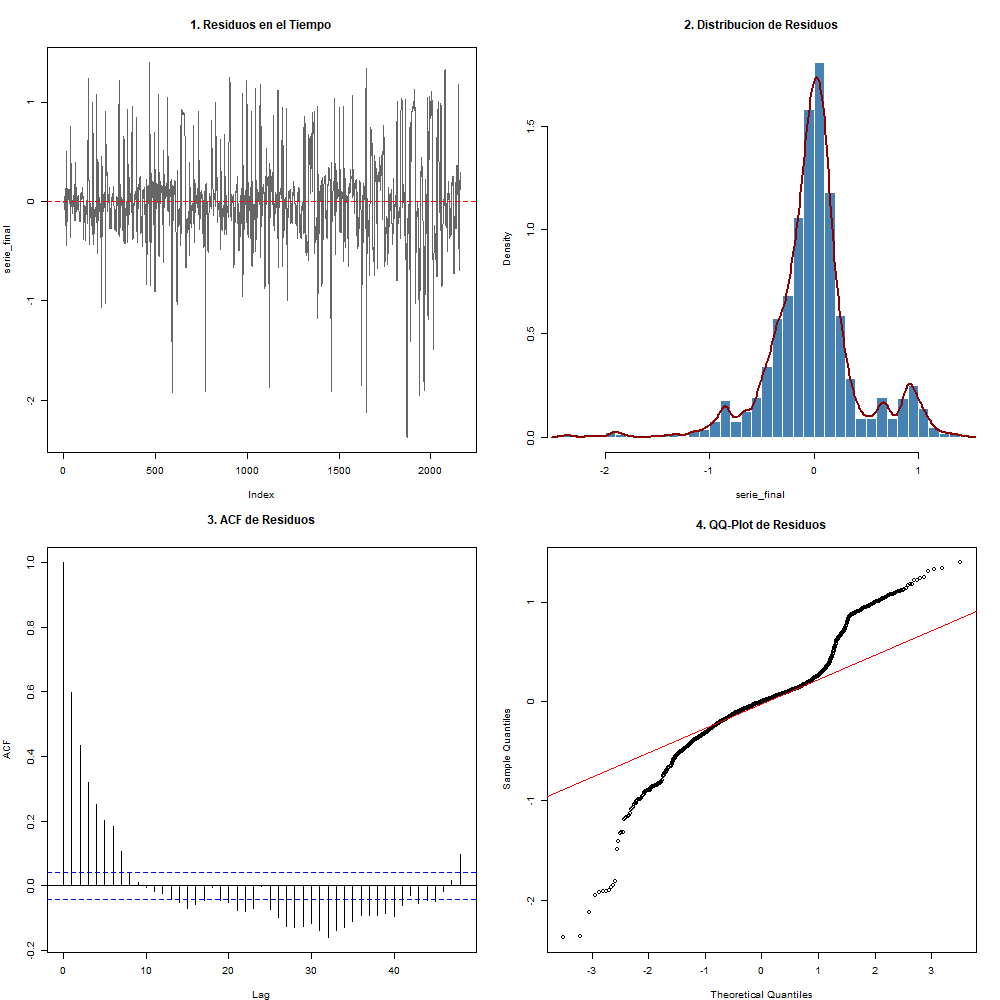

In [46]:
%%R -w 1000 -h 1000
# Celda 23: Diagnostico Completo de Residuos

library(tseries)
library(forecast)

serie_final <- na.omit(df_r$Trend_Removed)

# Panel de 2x2 para diagnostico visual
par(mfrow=c(2,2), mar=c(4,4,4,2))

# 1. Grafico de residuos
plot(serie_final, type="l", col="gray40", main="1. Residuos en el Tiempo")
abline(h=0, col="red", lty=2)

# 2. Histograma y densidad
hist(serie_final, breaks=50, border="white", col="steelblue", 
     main="2. Distribucion de Residuos", probability=TRUE)
lines(density(serie_final), col="darkred", lwd=2)

# 3. ACF (Autocorrelacion)
acf(serie_final, lag.max=48, main="3. ACF de Residuos")

# 4. QQ-Plot (Normalidad)
qqnorm(serie_final, main="4. QQ-Plot de Residuos")
qqline(serie_final, col="red")

par(mfrow=c(1,1))

# --- Tests Estadisticos ---
cat("\n", rep("=", 60), "\n", sep="")
cat(" DIAGNOSTICO DE RESIDUOS\n")
cat(rep("=", 60), "\n", sep="")

# Test de Normalidad (Jarque-Bera)
jb_test <- jarque.bera.test(serie_final)
cat("\n[A] Test de Jarque-Bera (Normalidad):\n")
cat(sprintf("   p-value: %.5f\n", jb_test$p.value))
cat(if(jb_test$p.value < 0.05) "   Resultado: No Normal\n" else "   Resultado: Normal\n")

# Test de Independencia (Ljung-Box)
lb_test <- Box.test(serie_final, lag=24, type="Ljung-Box")
cat("\n[B] Test Ljung-Box (Independencia - Es ruido blanco?):\n")
cat(sprintf("   p-value: %.5f\n", lb_test$p.value))
cat(if(lb_test$p.value < 0.05) "   Resultado: Autocorrelacion presente\n" else "   Resultado: Independientes (Ruido Blanco)\n")

cat("\n--- CONCLUSIONES ---\n")
cat("1. NO NORMALIDAD (Kurtosis > 3 o asimetria):\n")
cat("   -> Justifica uso de metricas robustas (CRPS, QuantileLoss)\n\n")

cat("2. AUTOCORRELACION RESIDUAL indica:\n")
cat("   - LOWESS no capturo toda la dinamica temporal\n")
cat("   - Modelos ARMA/LSTM manejaran esta estructura\n")
cat("   - Es normal en esta etapa exploratoria\n")

## 12. Análisis de Estacionalidad {#12-estacionalidad}

### 12.1 Box Plots por Período

In [47]:
# Celda 24: Preparación de Datos Temporales

df['Hora'] = df.index.hour
df['Dia_Semana'] = df.index.day_name()
df['Mes'] = df.index.month_name()

print("✅ Variables temporales creadas:")
print(f"  • Hora: 0-23")
print(f"  • Día: {df['Dia_Semana'].unique()}")
print(f"  • Mes: {df['Mes'].unique()}")

✅ Variables temporales creadas:
  • Hora: 0-23
  • Día: ['Tuesday' 'Wednesday' 'Thursday' 'Friday' 'Saturday' 'Sunday' 'Monday']
  • Mes: ['February' 'March' 'April' 'May']


In [ ]:
fig = px.box(df, x='Hora', y='Trend_Removed', 
             title='Estacionalidad Diaria: Perfil por Hora',
             labels={'Hora': 'Hora del Día', 'Trend_Removed': 'Residuo'},
             color_discrete_sequence=['#3498db'])

fig.update_layout(
    title_x=0.5,
    title_font_size=16,
    height=500
)
fig.show()

In [51]:
dias_orden = ["Monday", "Tuesday", "Wednesday", "Thursday", 
              "Friday", "Saturday", "Sunday"]

fig = px.box(df, x='Dia_Semana', y='Trend_Removed',
             category_orders={"Dia_Semana": dias_orden},
             title='Estacionalidad Semanal: Perfil por Día',
             labels={'Dia_Semana': 'Día de la Semana', 'Trend_Removed': 'Residuo'},
             color_discrete_sequence=['#e74c3c'])

fig.update_layout(
    title_x=0.5,
    title_font_size=16,
    height=500
)
fig.show()

### 12.2 Gráficos Estadísticos Avanzados (R)


--- Perfiles estacionales generados ---


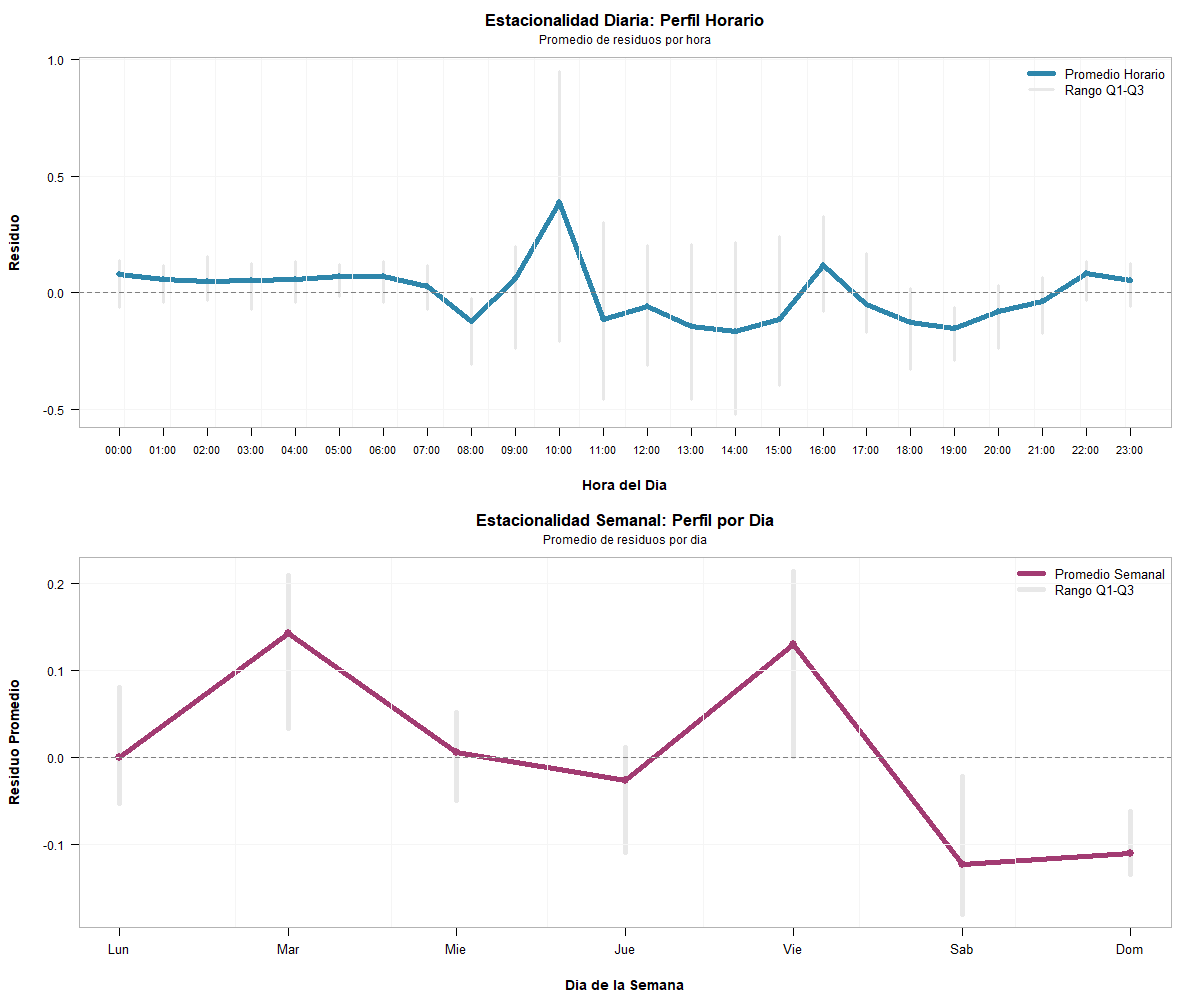

In [52]:
%%R -w 1200 -h 1000
# Celda 27: Perfiles Estacionales Detallados

library(dplyr)
library(lubridate)

# Paleta de colores
col_daily <- "#2E86AB"
col_weekly <- "#A23B72"
col_band <- "#E8E8E8"
col_grid <- "#F5F5F5"

layout(matrix(c(1, 2), nrow = 2, ncol = 1))
par(mar = c(5, 5.5, 4, 2), bg = "white", family = "sans")

# ==================================================================
# PANEL 1: ESTACIONALIDAD DIARIA
# ==================================================================

hourly_stats <- df_r %>%
  mutate(Hour = hour(Date)) %>%
  group_by(Hour) %>%
  summarise(
    Mean = mean(Trend_Removed, na.rm = TRUE),
    SD = sd(Trend_Removed, na.rm = TRUE),
    Q25 = quantile(Trend_Removed, 0.25, na.rm = TRUE),
    Q75 = quantile(Trend_Removed, 0.75, na.rm = TRUE)
  )

plot(hourly_stats$Hour, hourly_stats$Mean,
     type = "n",
     xlim = c(0, 23),
     ylim = range(c(hourly_stats$Q25, hourly_stats$Q75)),
     xlab = "", ylab = "", main = "", xaxt = "n", las = 1)

# Bandas intercuartiles
for(i in 1:nrow(hourly_stats)) {
  segments(hourly_stats$Hour[i], hourly_stats$Q25[i],
           hourly_stats$Hour[i], hourly_stats$Q75[i],
           col = col_band, lwd = 3)
}

# Linea de media
lines(hourly_stats$Hour, hourly_stats$Mean, 
      col = col_daily, lwd = 5)
points(hourly_stats$Hour, hourly_stats$Mean,
       col = col_daily, pch = 19, cex = 1.2)

# Decoracion (Sin acentos ni emojis)
axis(1, at = 0:23, labels = sprintf("%02d:00", 0:23), cex.axis = 0.9)
mtext("Estacionalidad Diaria: Perfil Horario", 
      side = 3, line = 2, cex = 1.4, font = 2)
mtext("Promedio de residuos por hora", 
      side = 3, line = 0.8, cex = 1)
mtext("Hora del Dia", side = 1, line = 3.5, cex = 1.2, font = 2)
mtext("Residuo", side = 2, line = 4, cex = 1.2, font = 2)

grid(nx = 24, ny = NULL, col = col_grid, lty = 1)
abline(h = 0, col = "gray50", lty = 2, lwd = 1.5)

legend("topright", 
       legend = c("Promedio Horario", "Rango Q1-Q3"), 
       col = c(col_daily, col_band), 
       lty = 1, lwd = c(5, 3), bty = "n", cex = 1.1)

box(col = "gray70", lwd = 1.5)

# ==================================================================
# PANEL 2: ESTACIONALIDAD SEMANAL
# ==================================================================

daily_agg <- df_r %>%
  mutate(Date_Day = as.Date(Date),
         Weekday = wday(Date_Day, week_start = 1)) %>%
  group_by(Date_Day, Weekday) %>%
  summarise(Value = mean(Trend_Removed, na.rm = TRUE), .groups = "drop")

weekly_stats <- daily_agg %>%
  group_by(Weekday) %>%
  summarise(
    Mean = mean(Value, na.rm = TRUE),
    SD = sd(Value, na.rm = TRUE),
    Q25 = quantile(Value, 0.25, na.rm = TRUE),
    Q75 = quantile(Value, 0.75, na.rm = TRUE)
  )

# Nombres de dias sin acentos
dias_semana <- c("Lun", "Mar", "Mie", "Jue", "Vie", "Sab", "Dom")

plot(weekly_stats$Weekday, weekly_stats$Mean,
     type = "n",
     xlim = c(1, 7),
     ylim = range(c(weekly_stats$Q25, weekly_stats$Q75)),
     xlab = "", ylab = "", main = "", xaxt = "n", las = 1)

# Bandas intercuartiles
for(i in 1:nrow(weekly_stats)) {
  segments(weekly_stats$Weekday[i], weekly_stats$Q25[i],
           weekly_stats$Weekday[i], weekly_stats$Q75[i],
           col = col_band, lwd = 5)
}

# Linea de media
lines(weekly_stats$Weekday, weekly_stats$Mean, 
      col = col_weekly, lwd = 5)
points(weekly_stats$Weekday, weekly_stats$Mean,
       col = col_weekly, pch = 19, cex = 1.5)

# Decoracion (Sin acentos ni emojis)
axis(1, at = 1:7, labels = dias_semana, cex.axis = 1.1)
mtext("Estacionalidad Semanal: Perfil por Dia", 
      side = 3, line = 2, cex = 1.4, font = 2)
mtext("Promedio de residuos por dia", 
      side = 3, line = 0.8, cex = 1)
mtext("Dia de la Semana", side = 1, line = 3.5, cex = 1.2, font = 2)
mtext("Residuo Promedio", side = 2, line = 4, cex = 1.2, font = 2)

grid(nx = 7, ny = NULL, col = col_grid, lty = 1)
abline(h = 0, col = "gray50", lty = 2, lwd = 1.5)

legend("topright", 
       legend = c("Promedio Semanal", "Rango Q1-Q3"), 
       col = c(col_weekly, col_band), 
       lty = 1, lwd = c(5, 5), bty = "n", cex = 1.1)

box(col = "gray70", lwd = 1.5)

cat("\n--- Perfiles estacionales generados ---\n")

---

## 13. Análisis Espectral {#13-espectral}

**Objetivo:** Identificar ciclos ocultos y validar las frecuencias dominantes mediante el dominio de la frecuencia (Transformada de Fourier).

**Teoría:**
- **Periodograma:** Estima la densidad espectral de potencia. Los picos indican las frecuencias que más contribuyen a la varianza de la serie.
- **Frecuencia (f):** Ciclos por unidad de tiempo.
- **Periodo (T):** $1/f$. Si la frecuencia es $0.0416$, el periodo es $1/0.0416 \approx 24$ horas.

### 13.1 Periodograma en R

Periodo Dominante detectado: 83.0769 horas


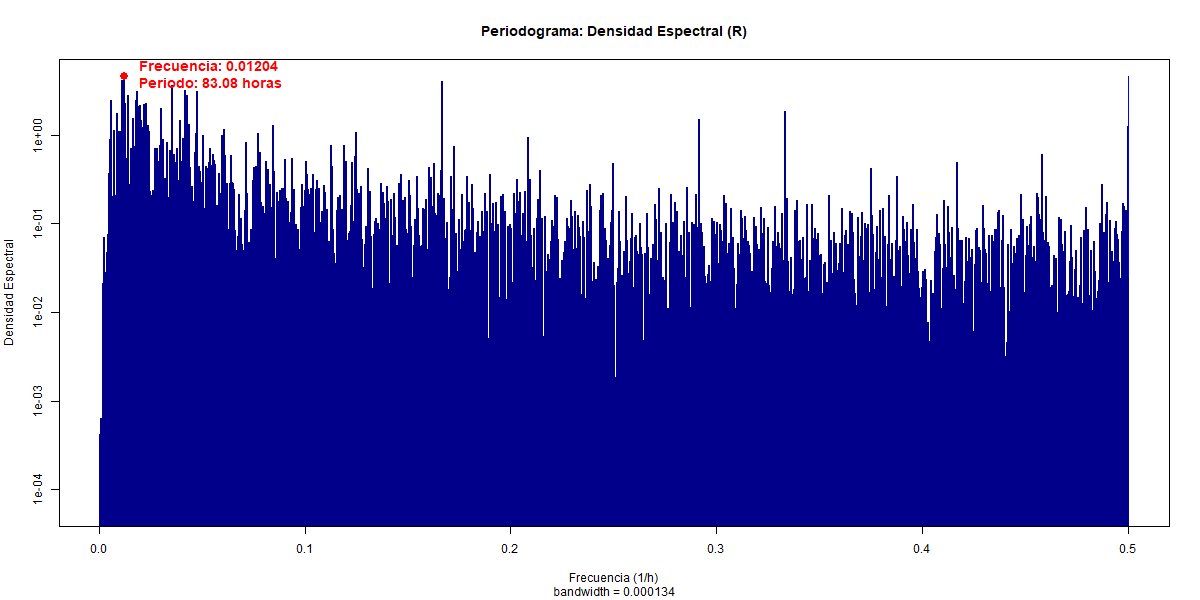

In [53]:
%%R -w 1200 -h 600
# Celda 28: Periodograma Raw

# 1. Preparar datos (quitamos NAs)
clean_data <- na.omit(df_r$Trend_Removed)

# 2. Calcular el periodograma
Periogram <- spectrum(as.numeric(clean_data), log = 'no', plot = FALSE)

# 3. Encontrar el pico maximo
ubicacion <- which.max(Periogram$spec)
max_freq <- Periogram$freq[ubicacion]
max_spec <- Periogram$spec[ubicacion]
max_period <- 1 / max_freq

# 4. Graficar
plot(Periogram, 
     main = "Periodograma: Densidad Espectral (R)",
     xlab = "Frecuencia (1/h)", ylab = "Densidad Espectral",
     col = "darkblue", lwd = 2, type="h")

# Marcamos el punto maximo
points(max_freq, max_spec, col = "red", pch = 19, cex = 1.5)

text(max_freq, max_spec, 
     sprintf("  Frecuencia: %.5f\n  Periodo: %.2f horas", max_freq, max_period), 
     pos = 4, col = "red", cex = 1.2, font = 2)

cat("Periodo Dominante detectado:", round(max_period, 4), "horas\n")

### 13.2 Análisis Multiespectral en Python (Welch)

**Ventaja:** El método de Welch suaviza el ruido del periodograma clásico dividiendo la serie en segmentos, lo que permite una estimación más robusta de las frecuencias.

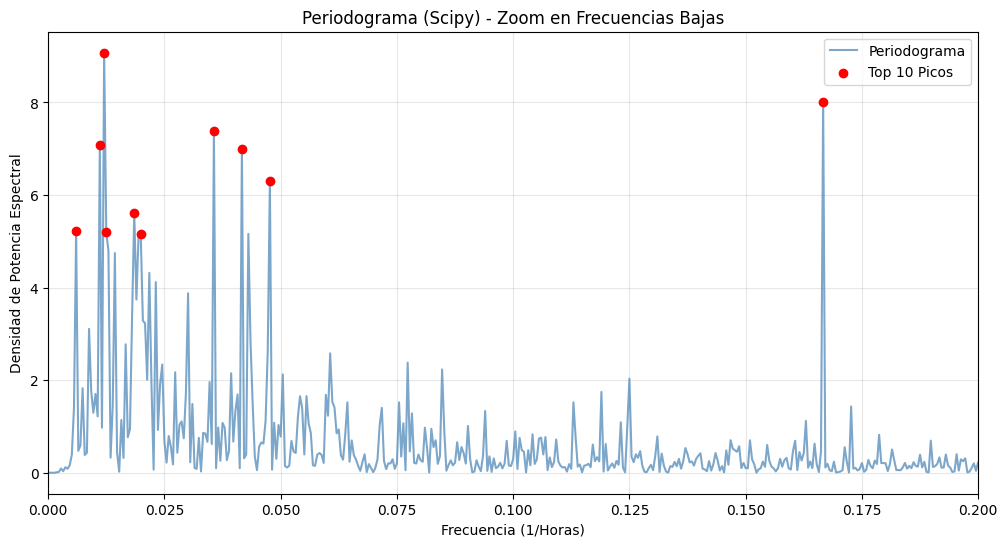

--- Los 10 Picos más grandes (Periodograma) ---


,0,1,2,3,4,5,6,7,8,9
Frecuencia,0.012037,0.166667,0.035648,0.011111,0.041667,0.047685,0.018519,0.006019,0.012500,0.019907
Periodo (Horas),83.076923,6.000000,28.051948,90.000000,24.000000,20.970874,54.000000,166.153846,80.000000,50.232558
Densidad Potencia,9.073767,8.015363,7.393022,7.086866,7.001416,6.302915,5.610105,5.211598,5.193203,5.160935


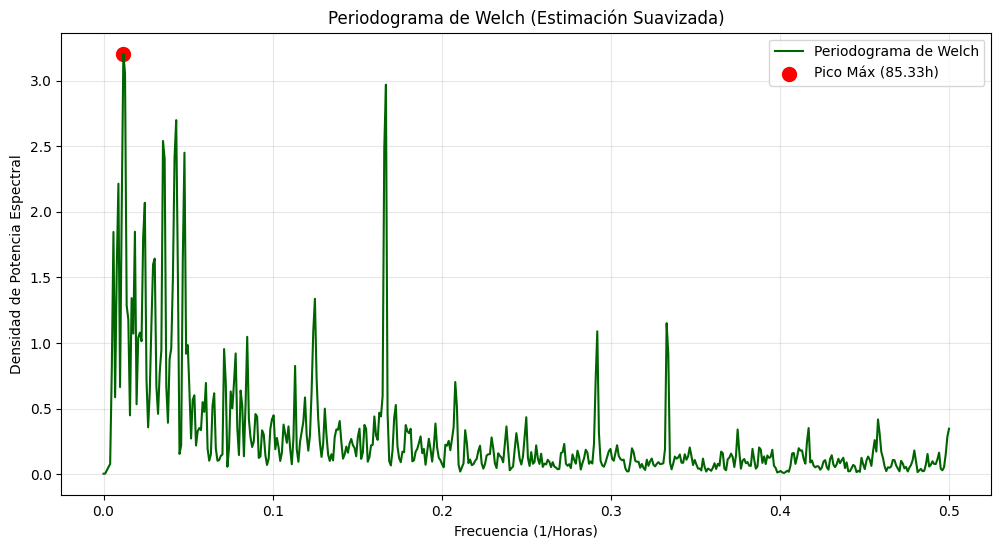


RESULTADO WELCH:
--------------------------------------------
El pico más notorio se da: 
 - Frecuencia: 0.01172 Hz (ciclos/hora)
 - Periodo:    85.33 Horas
 - Densidad:   3.21
--------------------------------------------



In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.signal as signal
import heapq

# 1. Preparar datos (Eliminar NAs es crucial para FFT)
trend_removed = df['Trend_Removed'].dropna()

# ==========================================
# A. PERIODOGRAMA ESTÁNDAR
# ==========================================

# Calcular el periodograma
f, Pxx_den = signal.periodogram(trend_removed)

# Encontrar los 10 picos más importantes
# Usamos heapq para buscar los índices de los valores más altos
peaks_indices = heapq.nlargest(10, range(len(Pxx_den)), key=Pxx_den.__getitem__)

f_freq = f[peaks_indices]
densidad = Pxx_den[peaks_indices]

# Evitar división por cero si la frecuencia 0 (DC) es seleccionada
with np.errstate(divide='ignore'):
    f_period = 1 / f_freq

# Graficar el periodograma estándar
plt.figure(figsize=(12, 6))
plt.plot(f, Pxx_den, label='Periodograma', color='steelblue', alpha=0.7)
plt.scatter(f[peaks_indices], Pxx_den[peaks_indices], color='red', zorder=5, label='Top 10 Picos')

# Zoom opcional: limitamos X para ver mejor las frecuencias bajas (donde están los ciclos de 24h y 168h)
plt.xlim(0, 0.2) 

plt.xlabel('Frecuencia (1/Horas)')
plt.ylabel('Densidad de Potencia Espectral')
plt.title('Periodograma (Scipy) - Zoom en Frecuencias Bajas')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print('--- Los 10 Picos más grandes (Periodograma) ---')

# Crear DataFrame con resultados
data = {
    'Frecuencia': f_freq, 
    'Periodo (Horas)': f_period, 
    'Densidad Potencia': densidad
}
df_frecuencias_periodos = pd.DataFrame(data).sort_values(by='Densidad Potencia', ascending=False)

# Mostrar tabla traspuesta para fácil lectura
display(df_frecuencias_periodos.T)


# ==========================================
# B. PERIODOGRAMA DE WELCH (Más suave)
# ==========================================

# Calcular Welch (nperseg define la resolución, 1024 es bueno para hourly)
f_welch, Pxx_den_welch = signal.welch(trend_removed, nperseg=1024)

# Encontrar el pico más alto
max_index_value_welch = np.argmax(Pxx_den_welch)
frecuencia_max_welch = f_welch[max_index_value_welch]
frecuencia_pico_welch = 1 / frecuencia_max_welch
max_densidad_welch = Pxx_den_welch[max_index_value_welch]

# Graficar Welch
plt.figure(figsize=(12, 6))
plt.plot(f_welch, Pxx_den_welch, label='Periodograma de Welch', color='darkgreen')
plt.scatter(frecuencia_max_welch, max_densidad_welch, color='red', s=100, label=f'Pico Máx ({frecuencia_pico_welch:.2f}h)')

plt.xlabel('Frecuencia (1/Horas)')
plt.ylabel('Densidad de Potencia Espectral')
plt.title('Periodograma de Welch (Estimación Suavizada)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"""
RESULTADO WELCH:
--------------------------------------------
El pico más notorio se da: 
 - Frecuencia: {frecuencia_max_welch:.5f} Hz (ciclos/hora)
 - Periodo:    {frecuencia_pico_welch:.2f} Horas
 - Densidad:   {max_densidad_welch:.2f}
--------------------------------------------
""")

## 14. Preparación para Modelado {#14-modelado}

**Objetivo:** Configurar el pipeline de predicción probabilística y evaluación de modelos.

**Enfoque Probabilístico:**
Dado que detectamos **heterocedasticidad** (Sección 9) y **no normalidad** (Sección 11), no utilizaremos solo errores puntuales (MSE/MAE). El estándar de oro para tu tesis será el **CRPS (Continuous Ranked Probability Score)**, que evalúa toda la distribución de la predicción.



In [65]:
# CELDA MÁGICA - EJECÚTALA PRIMERO EN TU NOTEBOOK ARMA.ipynb
import sys
import os

# Ruta al directorio que contiene todos los módulos (codigo_base)
CODE_BASE_PATH = r"C:\Users\pleal\Documents\Unal\Tesis\Codigo\Prediccion_Probabilistica\codigo_final_organizado\Aplicaciones\Aplicaciones_con_analisis\codigo_base"

# Añadimos al path para que Python los encuentre
if CODE_BASE_PATH not in sys.path:
    sys.path.insert(0, CODE_BASE_PATH)

print("Módulos cargados correctamente desde codigo_base")
print("Puedes usar: simulacion, pipeline, modelos, figuras, etc.")

Módulos cargados correctamente desde codigo_base
Puedes usar: simulacion, pipeline, modelos, figuras, etc.


In [67]:
import os
import pandas as pd
import numpy as np
from pipeline import PipelineProcessedData
# Importamos las funciones específicas de tu archivo plot.py
from plot import (
    generate_validation_report, 
    get_model_colors, 
    plot_type_a_vertical_stack, 
    plot_type_b_step_comparison, 
    run_advanced_statistics
)

# =============================================================================
# 1. EJECUCIÓN DEL MODELO (PIPELINE)
# =============================================================================
print("🚀 Iniciando Ejecución del Pipeline sobre datos procesados...")

# Asegúrate de tener la serie limpia (sin NaNs)
input_series = df['Trend_Removed'].dropna()

# Instanciar Pipeline
pipeline = PipelineProcessedData(n_boot=1000, seed=42, verbose=True)

# Ejecutar y obtener resultados crudos
# Es fundamental save_predictions=True para los gráficos de densidad
df_results, predictions_dict = pipeline.run_evaluation(input_series, save_predictions=True)

# =============================================================================
# 2. GENERACIÓN DE REPORTES Y GRAFICAS (ORQUESTADOR PERSONALIZADO)
# =============================================================================
output_folder = "Resultados_Analisis"
output_prefix = "Trend_Removed"

if not os.path.exists(output_folder):
    os.makedirs(output_folder)
    print(f"📂 Carpeta creada: {output_folder}")

print(f"\n📊 Generando Reportes en '{output_folder}'...")

# A. Identificar Modelos y Colores
model_names = [c for c in df_results.columns if c not in ['Paso', 'Valor_Observado', 'timestamp']]
color_map = get_model_colors(model_names)

# B. Generar Diagnóstico (PIT / Reliability)
# Esto retorna el DataFrame con datos de confiabilidad y guarda las imgs PIT/Reliability
df_reliability = generate_validation_report(predictions_dict, output_folder, output_prefix, color_map)

# C. GUARDAR EXCEL COMPLETO (CRPS + Reliability)
excel_name = os.path.join(output_folder, f"{output_prefix}_Resultados_Completos.xlsx")
with pd.ExcelWriter(excel_name, engine='openpyxl') as writer:
    df_results.to_excel(writer, sheet_name='Metricas_CRPS_Paso_a_Paso', index=False)
    if not df_reliability.empty:
        df_reliability.to_excel(writer, sheet_name='Reliability_Data', index=False)

print(f"💾 Excel guardado exitosamente: {excel_name}")

# =============================================================================
# 3. GENERACIÓN DE IMÁGENES
# =============================================================================

# Definir ranking para saber cuáles graficar juntos
# Calculamos el CRPS promedio por modelo
mean_scores = df_results[model_names].mean().sort_values()
sorted_models = mean_scores.index.tolist()

top_3_best = sorted_models[:3]
top_3_worst = sorted_models[-3:]
# Top 2 mejores + El peor (para contraste)
top_mixed = sorted_models[:2] + [sorted_models[-1]]

print("\n📸 Generando Gráficos Tipo A (Vertical Stack - Evolución Temporal)...")

# 1. Gráficos Individuales (Uno por modelo)
for model in model_names:
    plot_type_a_vertical_stack(
        group_name=f"Model_{model}",
        models_to_plot=[model],
        predictions_dict=predictions_dict,
        df_results=df_results,
        model_colors=color_map,
        output_folder=output_folder,
        output_prefix=output_prefix
    )

# 2. Gráficos Comparativos
if len(model_names) >= 3:
    plot_type_a_vertical_stack("Top3_Mejores", top_3_best, predictions_dict, df_results, color_map, output_folder, output_prefix)
    plot_type_a_vertical_stack("Top3_Peores", top_3_worst, predictions_dict, df_results, color_map, output_folder, output_prefix)
plot_type_a_vertical_stack("VS_Mejores_y_Peor", top_mixed, predictions_dict, df_results, color_map, output_folder, output_prefix)


print("\n📸 Generando Gráficos Tipo B (Corte Transversal - Pasos Específicos)...")
# Graficamos pasos clave: 1, 6, 12, 18, 24 (ajustable)
target_steps = [1, 6, 12, 18, 24]
for step in target_steps:
    if step <= len(predictions_dict):
        plot_type_b_step_comparison(
            target_step_idx=step,
            predictions_dict=predictions_dict,
            df_results=df_results,
            all_models=model_names,
            model_colors=color_map,
            output_folder=output_folder,
            output_prefix=output_prefix
        )

# =============================================================================
# 4. ANÁLISIS ESTADÍSTICO FINAL
# =============================================================================
print("\n🔬 Ejecutando Test de Diebold-Mariano y Rankings...")
run_advanced_statistics(df_results, output_folder)

print(f"\n✅ ¡PROCESO FINALIZADO! Revisa la carpeta: {os.path.abspath(output_folder)}")

🚀 Iniciando Ejecución del Pipeline sobre datos procesados...
📥 PROCESSED DATA PIPELINE (Datos Recibidos: 2160 puntos)

⚡ OPTIMIZACIÓN EFICIENTE (9 Modelos)


Optimizando DeepAR:  78%|███████▊  | 7/9 [01:16<00:20, 10.13s/modelo]             

  Early stopping at epoch 8
  Early stopping at epoch 8
  Early stopping at epoch 7
  Early stopping at epoch 10
  Early stopping at epoch 9
  Early stopping at epoch 7
  Early stopping at epoch 11
  Early stopping at epoch 13
  Early stopping at epoch 9
  Early stopping at epoch 15
  Early stopping at epoch 11
  Early stopping at epoch 11
  Early stopping at epoch 9
  Early stopping at epoch 10
  Early stopping at epoch 10
  Early stopping at epoch 12
  Early stopping at epoch 12
  Early stopping at epoch 15
  Early stopping at epoch 7


Optimizando EnCQR-LSTM: 100%|██████████| 9/9 [31:30<00:00, 210.04s/modelo]



🔒 Fase 2: Congelamiento (Entrenamiento Final)


Congelando modelos:  67%|██████▋   | 6/9 [00:00<00:00, 34.89it/s]

  CBB congelado: block_length=24
  Sieve Bootstrap congelado: order=12, n_residuos=2124
  LSPM congelado: n_lags=12
  LSPM congelado: n_lags=12
  ✅ LSPMW congelado: ρ=0.95, n_lags=12, n_critical=2123
  AREPD congelado: n_lags=24, rho=0.9, mean=-0.0012, std=0.4240
  MCPS congelado: n_lags=24, n_bins=10
  DeepAR congelado: mean=-0.0012, std=0.4240, model_trained=True


Congelando modelos: 100%|██████████| 9/9 [00:57<00:00,  6.38s/it]


  ✓ EnCQR-LSTM congelado con KDE: n_lags=24, B=3, units=48

🔮 Fase 3: Predicción (24 pasos)


Prediciendo Steps: 100%|██████████| 24/24 [00:45<00:00,  1.90s/it]


📂 Carpeta creada: Resultados_Analisis

📊 Generando Reportes en 'Resultados_Analisis'...
 📊 Generando Reporte Estadístico Agregado (Diagnóstico)...
💾 Excel guardado exitosamente: Resultados_Analisis\Trend_Removed_Resultados_Completos.xlsx

📸 Generando Gráficos Tipo A (Vertical Stack - Evolución Temporal)...

📸 Generando Gráficos Tipo B (Corte Transversal - Pasos Específicos)...

🔬 Ejecutando Test de Diebold-Mariano y Rankings...

🔬 Ejecutando Análisis Estadístico en 'Resultados_Analisis\Analisis'...
   ✓ Ranking DM guardado: Resultados_Analisis\Analisis\Ranking_Estadistico_DM.xlsx

✅ ¡PROCESO FINALIZADO! Revisa la carpeta: c:\Users\pleal\Documents\Unal\Tesis\Codigo\Prediccion_Probabilistica\codigo_final_organizado\Aplicaciones\Aplicaciones_con_analisis\Resultados_Analisis
